In [16]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

import psycopg2

from sqlalchemy import create_engine, inspect
from sqlalchemy import DATE, DATETIME, FLOAT, VARCHAR, INTEGER, DateTime

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import glob
import os

from unidecode import unidecode

In [17]:
pd.options.display.float_format = '{:,.2f}'.format

In [18]:
pd.set_option('display.max_row', 300)
pd.set_option('display.max_columns', 60)

folder = 'D:/Fichiers_dev/test_xml/table2_analyse/'
folder_powerbi = 'D:/Fichiers_dev/test_xml/powerbi/tables_powerbi/'

In [19]:
# se positionner dans le répertoire où il y a mes fichiers
repertoire_table = os.chdir(folder)

liste_fichiers_tables = os.listdir(repertoire_table)
liste_fichiers_tables

# creation df avec les fichiers du dossier et leur taille
tailles_fichiers = []

for fichier in liste_fichiers_tables:
    tailles_fichiers.append(os.path.getsize(fichier))
    
dico = {'fichiers':liste_fichiers_tables,
       'tailles':tailles_fichiers}

fichiers_tailles = pd.DataFrame(dico)

# fichier classés par taille
fichiers_tailles = fichiers_tailles.sort_values('tailles', ascending=False)

In [ ]:
# liste des plus gros fichiers
for fichier in fichiers_tailles['fichiers'].values[:]:
    print(f"{fichier.replace('.csv', '')} = pd.read_csv(folder + '{fichier}')")

ressources = pd.read_csv(folder + 'ressources.csv')
participationDirigeantDto = pd.read_csv(folder + 'participationDirigeantDto.csv')
declarations = pd.read_csv(folder + 'declarations.csv')
mandatElectifDto = pd.read_csv(folder + 'mandatElectifDto.csv')
activProfCinqDerniereDto = pd.read_csv(folder + 'activProfCinqDerniereDto.csv')
individus = pd.read_csv(folder + 'individus.csv')
participationFinanciereDto = pd.read_csv(folder + 'participationFinanciereDto.csv')
activProfConjointDto = pd.read_csv(folder + 'activProfConjointDto.csv')
fonctionBenevoleDto = pd.read_csv(folder + 'fonctionBenevoleDto.csv')
activCollaborateursDto = pd.read_csv(folder + 'activCollaborateursDto.csv')
attached_files = pd.read_csv(folder + 'attached_files.csv')
observationInteretDto = pd.read_csv(folder + 'observationInteretDto.csv')
activConsultantDto = pd.read_csv(folder + 'activConsultantDto.csv')
comptesBancaireDto = pd.read_csv(folder + 'comptesBancaireDto.csv')
immeubleDto = pd.read_csv(folder + 'immeuble

In [21]:
ressources = pd.read_csv(folder + 'ressources.csv')
participationDirigeantDto = pd.read_csv(folder + 'participationDirigeantDto.csv')
declarations = pd.read_csv(folder + 'declarations.csv')
mandatElectifDto = pd.read_csv(folder + 'mandatElectifDto.csv')
activProfCinqDerniereDto = pd.read_csv(folder + 'activProfCinqDerniereDto.csv')
individus = pd.read_csv(folder + 'individus.csv')
participationFinanciereDto = pd.read_csv(folder + 'participationFinanciereDto.csv')
activProfConjointDto = pd.read_csv(folder + 'activProfConjointDto.csv')
fonctionBenevoleDto = pd.read_csv(folder + 'fonctionBenevoleDto.csv')
activCollaborateursDto = pd.read_csv(folder + 'activCollaborateursDto.csv')
attached_files = pd.read_csv(folder + 'attached_files.csv')
observationInteretDto = pd.read_csv(folder + 'observationInteretDto.csv')
activConsultantDto = pd.read_csv(folder + 'activConsultantDto.csv')
comptesBancaireDto = pd.read_csv(folder + 'comptesBancaireDto.csv')
immeubleDto = pd.read_csv(folder + 'immeubleDto.csv')
assuranceVieDto = pd.read_csv(folder + 'assuranceVieDto.csv')
passifDto = pd.read_csv(folder + 'passifDto.csv')
sciDto_immeubles = pd.read_csv(folder + 'sciDto_immeubles.csv')
valeursEnBourseDto = pd.read_csv(folder + 'valeursEnBourseDto.csv')
sciDto = pd.read_csv(folder + 'sciDto.csv')
vehiculeDto = pd.read_csv(folder + 'vehiculeDto.csv')
valeursNonEnBourseDto = pd.read_csv(folder + 'valeursNonEnBourseDto.csv')
autreBienDto = pd.read_csv(folder + 'autreBienDto.csv')
bienEtrangerDto = pd.read_csv(folder + 'bienEtrangerDto.csv')
observationPatrimoineDto = pd.read_csv(folder + 'observationPatrimoineDto.csv')
bienDiverDto = pd.read_csv(folder + 'bienDiverDto.csv')
fondDto = pd.read_csv(folder + 'fondDto.csv')

## Fonctions

In [22]:
def modif_champs_societe(valeur):
    '''Supprime [Données non publiées], enlève les accents et mets en majuscule.'''
    
    try :
        valeur = valeur.replace('[Données non publiées]', '')
        valeur = valeur.strip()
        # enlève les accents
        valeur = unidecode(valeur)
        valeur = valeur.upper()
        
    except Exception as error:
        print(error)
    
    return valeur

In [23]:
def modif_champs_activite(table, champs):

    table[champs] = table[champs].apply(modif_champs_societe)
    table.loc[table[champs]=='', champs] = '[Données non publiées]'
    
    return table

### Standardisation des variables catégorielles utiles pour l'analyse

In [24]:
# standardisation des types mandats

# catégorie à modifier
epci = ["Dirigeant d'une société publique locale", "Dirigeant d'une société d’économie mixte", "Vice president", "Vice Pr?sidente"]
maire = ["Membre de cabinet du maire d'une ville de plus de 20 000 habitants"]
elu_departemental = ["Elu d?partemental/Savoie (73)/", "elu departemental"]

# modifications
declarations.loc[declarations['qualite_mandat_label_type_mandat'].isin(epci), 'qualite_mandat_label_type_mandat'] = "Membre d’EPCI"
declarations.loc[declarations['qualite_mandat_label_type_mandat'].isin(maire), 'qualite_mandat_label_type_mandat'] = "Maire ou adjoint municipal"
declarations.loc[declarations['qualite_mandat_label_type_mandat'].isin(elu_departemental), 'qualite_mandat_label_type_mandat'] = "Elu départemental"

In [25]:
#### Remplacement des 'qualite_mandat_label_type_mandat' manquant par 'qualite_mandat_nom_categorie_mandat' 
# si non manquant ou sinon par 'Type mandat manquant'

declarations.loc[(declarations['qualite_mandat_label_type_mandat'].isna()) & (declarations['qualite_mandat_nom_categorie_mandat'].notna()),
         'qualite_mandat_label_type_mandat'] = declarations.loc[(declarations['qualite_mandat_label_type_mandat'].isna()) & (declarations['qualite_mandat_nom_categorie_mandat'].notna()),
                                                        'qualite_mandat_nom_categorie_mandat']

# remplacement des valeurs manquantes par 'type manquant'
declarations.loc[(declarations['qualite_mandat_label_type_mandat'].isna()), 'qualite_mandat_label_type_mandat'] = 'Type mandat manquant'
declarations.loc[(declarations['qualite_mandat_nom_categorie_mandat'].isna()), 'qualite_mandat_nom_categorie_mandat'] = 'Catégorie mandat manquante'

In [26]:
# standardisation nom_societe

participationFinanciereDto = modif_champs_activite(table=participationFinanciereDto, champs='nom_societe')

In [27]:
# standardisation description et employeur

activProfCinqDerniereDto = modif_champs_activite(table=activProfCinqDerniereDto, champs='description')
activProfCinqDerniereDto = modif_champs_activite(table=activProfCinqDerniereDto, champs='employeur')

In [28]:
# standardisation nom_employeur

activConsultantDto = modif_champs_activite(table=activConsultantDto, champs='nom_employeur')

In [29]:
# standardisation nom_societe

participationDirigeantDto = modif_champs_activite(table=participationDirigeantDto, champs='nom_societe')

'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'r

### Suppression des doublons individus

In [30]:
# suppression dans individus
individus = individus.drop(individus[individus['id_individu'].isin([216,1672,2387,3236,3439,3888,3955,4399,4604,198,5361,
                                                                    5344,1544,2583,3809,4710,4594,4998,1363,5633])].index)

In [31]:
declarations_a_supprimer = declarations[declarations['id_individu'].isin([216,1672,2387,3236,3439,3888,3955,4399,4604,198,5361,
                                                                    5344,1544,2583,3809,4710,4594,4998,1363,5633])]['id_declaration'].values
declarations_a_supprimer

array([  380,   452,   872,  1331,  2012,  2194,  2574,  3325,  3439,
        4011,  4523,  4922,  5166,  5188,  5328,  5538,  5819,  5959,
        6341,  6565,  7335,  7791,  7851,  8203,  9099,  9630,  9898,
       10675, 10817], dtype=int64)

In [32]:
# liste des plus gros fichiers
for fichier in fichiers_tailles['fichiers'].values[:]:
    nom_fichier = fichier.replace('.csv', '')
    
    print(f"nombre_ligne_avant = {nom_fichier}.shape[0]")
    print(f"{nom_fichier} = {nom_fichier}.drop({nom_fichier}[{nom_fichier}['id_declaration'].isin(declarations_a_supprimer)].index)")
    print(f"nombre_ligne_apres = {nom_fichier}.shape[0]")
    
    print('print(',"f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table'", f",'{nom_fichier}')")

nombre_ligne_avant = ressources.shape[0]
ressources = ressources.drop(ressources[ressources['id_declaration'].isin(declarations_a_supprimer)].index)
nombre_ligne_apres = ressources.shape[0]
print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'ressources')
nombre_ligne_avant = participationDirigeantDto.shape[0]
participationDirigeantDto = participationDirigeantDto.drop(participationDirigeantDto[participationDirigeantDto['id_declaration'].isin(declarations_a_supprimer)].index)
nombre_ligne_apres = participationDirigeantDto.shape[0]
print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'participationDirigeantDto')
nombre_ligne_avant = declarations.shape[0]
declarations = declarations.drop(declarations[declarations['id_declaration'].isin(declarations_a_supprimer)].index)
nombre_ligne_apres = declarations.shape[0]
print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'decla

In [33]:
# suppression des tables liés aux individus en doublons dans toutes les tables

try :
    
    nombre_ligne_avant = ressources.shape[0]
    ressources = ressources.drop(ressources[ressources['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = ressources.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'ressources')
    nombre_ligne_avant = participationDirigeantDto.shape[0]
    participationDirigeantDto = participationDirigeantDto.drop(participationDirigeantDto[participationDirigeantDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = participationDirigeantDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'participationDirigeantDto')
    nombre_ligne_avant = declarations.shape[0]
    declarations = declarations.drop(declarations[declarations['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = declarations.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'declarations')
    nombre_ligne_avant = mandatElectifDto.shape[0]
    mandatElectifDto = mandatElectifDto.drop(mandatElectifDto[mandatElectifDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = mandatElectifDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'mandatElectifDto')
    nombre_ligne_avant = activProfCinqDerniereDto.shape[0]
    activProfCinqDerniereDto = activProfCinqDerniereDto.drop(activProfCinqDerniereDto[activProfCinqDerniereDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = activProfCinqDerniereDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'activProfCinqDerniereDto')
    nombre_ligne_avant = participationFinanciereDto.shape[0]
    participationFinanciereDto = participationFinanciereDto.drop(participationFinanciereDto[participationFinanciereDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = participationFinanciereDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'participationFinanciereDto')
    nombre_ligne_avant = activProfConjointDto.shape[0]
    activProfConjointDto = activProfConjointDto.drop(activProfConjointDto[activProfConjointDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = activProfConjointDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'activProfConjointDto')
    nombre_ligne_avant = fonctionBenevoleDto.shape[0]
    fonctionBenevoleDto = fonctionBenevoleDto.drop(fonctionBenevoleDto[fonctionBenevoleDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = fonctionBenevoleDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'fonctionBenevoleDto')
    nombre_ligne_avant = activCollaborateursDto.shape[0]
    activCollaborateursDto = activCollaborateursDto.drop(activCollaborateursDto[activCollaborateursDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = activCollaborateursDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'activCollaborateursDto')
    nombre_ligne_avant = attached_files.shape[0]
    attached_files = attached_files.drop(attached_files[attached_files['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = attached_files.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'attached_files')
    nombre_ligne_avant = observationInteretDto.shape[0]
    observationInteretDto = observationInteretDto.drop(observationInteretDto[observationInteretDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = observationInteretDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'observationInteretDto')
    nombre_ligne_avant = activConsultantDto.shape[0]
    activConsultantDto = activConsultantDto.drop(activConsultantDto[activConsultantDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = activConsultantDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'activConsultantDto')
    nombre_ligne_avant = comptesBancaireDto.shape[0]
    comptesBancaireDto = comptesBancaireDto.drop(comptesBancaireDto[comptesBancaireDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = comptesBancaireDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'comptesBancaireDto')
    nombre_ligne_avant = immeubleDto.shape[0]
    immeubleDto = immeubleDto.drop(immeubleDto[immeubleDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = immeubleDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'immeubleDto')
    nombre_ligne_avant = assuranceVieDto.shape[0]
    assuranceVieDto = assuranceVieDto.drop(assuranceVieDto[assuranceVieDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = assuranceVieDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'assuranceVieDto')
    nombre_ligne_avant = passifDto.shape[0]
    passifDto = passifDto.drop(passifDto[passifDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = passifDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'passifDto')
    nombre_ligne_avant = sciDto_immeubles.shape[0]
    sciDto_immeubles = sciDto_immeubles.drop(sciDto_immeubles[sciDto_immeubles['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = sciDto_immeubles.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'sciDto_immeubles')
    nombre_ligne_avant = valeursEnBourseDto.shape[0]
    valeursEnBourseDto = valeursEnBourseDto.drop(valeursEnBourseDto[valeursEnBourseDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = valeursEnBourseDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'valeursEnBourseDto')
    nombre_ligne_avant = sciDto.shape[0]
    sciDto = sciDto.drop(sciDto[sciDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = sciDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'sciDto')
    nombre_ligne_avant = vehiculeDto.shape[0]
    vehiculeDto = vehiculeDto.drop(vehiculeDto[vehiculeDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = vehiculeDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'vehiculeDto')
    nombre_ligne_avant = valeursNonEnBourseDto.shape[0]
    valeursNonEnBourseDto = valeursNonEnBourseDto.drop(valeursNonEnBourseDto[valeursNonEnBourseDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = valeursNonEnBourseDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'valeursNonEnBourseDto')
    nombre_ligne_avant = autreBienDto.shape[0]
    autreBienDto = autreBienDto.drop(autreBienDto[autreBienDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = autreBienDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'autreBienDto')
    nombre_ligne_avant = bienEtrangerDto.shape[0]
    bienEtrangerDto = bienEtrangerDto.drop(bienEtrangerDto[bienEtrangerDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = bienEtrangerDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'bienEtrangerDto')
    nombre_ligne_avant = observationPatrimoineDto.shape[0]
    observationPatrimoineDto = observationPatrimoineDto.drop(observationPatrimoineDto[observationPatrimoineDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = observationPatrimoineDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'observationPatrimoineDto')
    nombre_ligne_avant = bienDiverDto.shape[0]
    bienDiverDto = bienDiverDto.drop(bienDiverDto[bienDiverDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = bienDiverDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'bienDiverDto')
    nombre_ligne_avant = fondDto.shape[0]
    fondDto = fondDto.drop(fondDto[fondDto['id_declaration'].isin(declarations_a_supprimer)].index)
    nombre_ligne_apres = fondDto.shape[0]
    print( f'{nombre_ligne_apres - nombre_ligne_avant} lignes ont été supprimées dans la table' ,'fondDto')
    
except Exception as error:
    print(error)    

-858 lignes ont été supprimées dans la table ressources
-97 lignes ont été supprimées dans la table participationDirigeantDto
-29 lignes ont été supprimées dans la table declarations
-70 lignes ont été supprimées dans la table mandatElectifDto
-36 lignes ont été supprimées dans la table activProfCinqDerniereDto
-19 lignes ont été supprimées dans la table participationFinanciereDto
-15 lignes ont été supprimées dans la table activProfConjointDto
-3 lignes ont été supprimées dans la table fonctionBenevoleDto
-19 lignes ont été supprimées dans la table activCollaborateursDto
-35 lignes ont été supprimées dans la table attached_files
-5 lignes ont été supprimées dans la table observationInteretDto
-5 lignes ont été supprimées dans la table activConsultantDto
-3 lignes ont été supprimées dans la table comptesBancaireDto
0 lignes ont été supprimées dans la table immeubleDto
-1 lignes ont été supprimées dans la table assuranceVieDto
0 lignes ont été supprimées dans la table passifDto
0 lignes

## Analyse declarations

In [34]:
declarations.head(50)

,id_declaration,id_individu,activ_collaborateurs_dto_neant,activ_consultant_dto_neant,activ_prof_cinq_derniere_dto_neant,activ_prof_conjoint_dto_neant,assurance_vie_dto_neant,autre_bien_dto_neant,bien_diver_dto_neant,bien_etranger_dto_neant,chiffre_affaire,complete,comptes_bancaire_dto_neant,date_debut_mandat,date_depot,declaration_modificative,declaration_version,evenement_majeur_dto_neant,fonction_benevole_dto_neant,fond_dto_neant,immeuble_dto_neant,mandat_electif_dto_neant,mandat_label,nom_societe,nom_societe_mere,observation_interet_dto_neant,observation_patrimoine_dto_neant,organe_code_liste_organe,organe_code_organe,organe_label_declaration,organe_label_organe,organe_nom_liste_organe,organe_organe_parent,origine,participation_dirigeant_dto_neant,participation_financiere_dto_neant,passif_dto_neant,qualite_declarant,qualite_declarant_for_p_d_f,qualite_mandat_cod_categorie_mandat,qualite_mandat_cod_type_mandat_fichier,qualite_mandat_code_liste_organe,qualite_mandat_label_organe,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,qualite_mandat_type_mandat,regime_matrimonial,regime_matrimonial_comments,revenu_mandat_dto_neant,sci_dto_neant,type_declaration_id,type_declaration_label,uuid,valeurs_en_bourse_dto_neant,valeurs_non_en_bourse_dto_neant,vehicule_dto_neant
0,0,1432,False,True,False,True,NaN,NaN,NaN,NaN,NaN,True,NaN,15/03/2020,2021-02-08 19:58:13,False,"20,171,221.00",NaN,True,NaN,NaN,False,Elu local ou membre d’un établissement public ...,NaN,NaN,True,NaN,NaN,NaN,NaN,Versailles grand parc,NaN,NaN,ADEL,True,True,NaN,NaN,Membre d’EPCI/Versailles grand parc,LOC,epci,NaN,EPCI,Membre d’EPCI,Elu local ou membre d’EPCI,Membre d’EPCI,NaN,NaN,NaN,NaN,DI,Déclaration d'intérêts,000765d9-da68-48c6-a95d-f34a12cacb5f,NaN,NaN,NaN
1,1,4608,False,True,False,False,NaN,NaN,NaN,NaN,NaN,True,NaN,28/06/2020,2020-08-17 19:27:35,NaN,"20,171,221.00",NaN,True,NaN,NaN,True,Elu local ou membre d’un établissement public ...,NaN,NaN,True,NaN,COMM,33063,NaN,Bordeaux (33),Communes +20KH,NaN,ADEL,True,True,NaN,ADJOINT EDUCATION ENFANCE JEUNESSE,Maire ou adjoint municipal/Bordeaux (33)/ADJOI...,LOC,commune,COMM,Commune,Maire ou adjoint municipal,Elu local ou membre d’EPCI,Maire ou adjoint municipal,NaN,NaN,NaN,NaN,DI,Déclaration d'intérêts,00138e83-44ec-4da1-89f3-37d2309a62a2,NaN,NaN,NaN
2,2,3921,False,True,False,False,NaN,NaN,NaN,NaN,NaN,True,NaN,01/07/2021,2021-11-22 16:19:31,True,"20,171,221.00",NaN,True,NaN,NaN,False,Membre ou dirigeant d’une autorité administrat...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADEL,False,True,NaN,PRESIDENT DU CONSEIL GENERAL,PRESIDENT DU CONSEIL GENERAL,AAI,aai,AAI,AAI,Membre d’une AAI,Membre d’une AAI,Membre,NaN,NaN,NaN,NaN,DI,Déclaration d'intérêts modificative,0014115c-cbae-4bdd-98d1-39c8e6062095,NaN,NaN,NaN
3,3,2308,False,True,True,False,NaN,NaN,NaN,NaN,NaN,True,NaN,28/09/2014,2021-02-24 10:25:03,True,"20,171,221.00",NaN,False,NaN,NaN,False,Député ou sénateur,NaN,NaN,False,NaN,ZEP,35,NaN,Ille-et-Vilaine(35),Zones d'élection des parlementaires,NaN,ADEL,True,False,NaN,NaN,Sénateur/Ille-et-Vilaine(35),PAR,senateur,ZEP,Département d'élection,Sénateur,Député ou sénateur,Sénateur,NaN,NaN,NaN,NaN,DIA,Déclaration d'intérêts et d'activités modifica...,0020c869-c893-40ff-b7c4-42aeb8f6d1c0,NaN,NaN,NaN
4,4,5611,False,True,False,True,NaN,NaN,NaN,NaN,NaN,True,NaN,26/06/2021,2021-09-01 10:38:28,True,"20,171,221.00",NaN,False,NaN,NaN,False,Elu local ou membre d’un établissement public ...,NaN,NaN,True,NaN,DEP,76,NaN,Seine-Maritime (76),Départements,28,ADEL,False,True,NaN,NaN,Elu départemental/Seine-Maritime (76),LOC,departement,DEP,Département,Elu départemental,Elu local ou membre d’EPCI,Elu départemental,NaN,NaN,NaN,NaN,DI,Déclaration d'intérêts modificative,00243ad5-2191-4efc-884b-df9213413b17,NaN,NaN,NaN
5,5,5398,False,False,False,False,NaN,NaN,NaN,NaN,NaN,True,NaN,02/07/2021,2021-12-07 20:27:52,False,"20,171,221.00",NaN,True,NaN,NaN,True,Elu local ou membre d’un établissement public ...,NaN,NaN,True,NaN,REG

In [35]:
declarations['type_declaration_id'].value_counts()

DI       8718
DIA      2041
DSP        82
DSPFM       4
Name: type_declaration_id, dtype: int64

In [36]:
for type_declaration in declarations['type_declaration_id'].unique():
    print(type_declaration)
    print(declarations.loc[declarations['type_declaration_id']==type_declaration, 'type_declaration_label'].value_counts())
    print('_'*100)

DI
Déclaration d'intérêts                 6147
Déclaration d'intérêts modificative    2571
Name: type_declaration_label, dtype: int64
____________________________________________________________________________________________________
DIA
Déclaration d'intérêts et d'activités                 1378
Déclaration d'intérêts et d'activités modificative     663
Name: type_declaration_label, dtype: int64
____________________________________________________________________________________________________
DSP
Déclaration de situation patrimoniale                 42
Déclaration de situation patrimoniale modificative    29
Déclaration initiale de situation patrimoniale        11
Name: type_declaration_label, dtype: int64
____________________________________________________________________________________________________
DSPFM
Déclaration de situation patrimoniale    4
Name: type_declaration_label, dtype: int64
________________________________________________________________________________________

In [37]:
declarations['qualite_mandat_label_organe'].value_counts()

EPCI                      3084
Commune                   2210
Département               2089
Département d'élection    2018
Région                     625
Collectivité               185
Intitulé du ministère      116
AAI                         47
Nom de la société            4
Nom de la structure          2
Name: qualite_mandat_label_organe, dtype: int64

In [38]:
declarations['qualite_mandat_type_mandat'].value_counts()

Membre d’EPCI                                            3084
Maire ou adjoint municipal                               2209
Elu départemental                                        2089
Député                                                   1165
Sénateur                                                  853
Elu régional                                              625
Collectivité à statut particulier                         185
Membre                                                    176
?Membre                                                   116
Autre                                                      94
Dirigeant société publique locale                           2
Dirigeant société d’économie mixte                          2
vice presidente du conseil d?partemental de la Savoie       1
elu departemental                                           1
Membre cabinet maire                                        1
Vice pr?sident                                              1
Vice pre

## Modification declarations, conservation de la dernière version uniquement

In [39]:
declarations['type_declaration_label'].value_counts()

Déclaration d'intérêts                                6147
Déclaration d'intérêts modificative                   2571
Déclaration d'intérêts et d'activités                 1378
Déclaration d'intérêts et d'activités modificative     663
Déclaration de situation patrimoniale                   46
Déclaration de situation patrimoniale modificative      29
Déclaration initiale de situation patrimoniale          11
Name: type_declaration_label, dtype: int64

In [40]:
declarations.shape

(10845, 56)

In [41]:
def derniere_declaration_par_type_declaration(declarations, type_declaration_id, colonnes_gardees):
    '''Pour chaque type de déclaration, va uniquement garder la dernière déposée.'''
    
    # declarations du type traité
    declarations_type = declarations[declarations['type_declaration_id'].isin(type_declaration_id)]
    
    # declarations par individu et par date_depot
    declarations_type = declarations_type.sort_values(['id_individu', 'date_depot'])
    
    # window fonction en python, classement par individu puis par date_depot, par ordre croissant donc date_depot la plus grande
    # et donc la plus recente en dernier
    # groupby sur id_individu et rang sur la date_depot method 'first' en ascending=False
    # càd method 'last' -> la date la plus recente sera ranker en premier
    declarations_type['rank'] = declarations_type.sort_values(['id_individu',
                                   'date_depot']).groupby('id_individu')['date_depot'].rank(method='first', ascending=False)
    
    # on garde uniquement la dernière déclaration
    declarations_type = declarations_type.loc[declarations_type['rank']==1, :].drop(columns='rank')

    return declarations_type[colonnes_gardees]

In [42]:
# colonnes gardées de declarations pour la suite
colonnes_gardees = ['id_declaration', 'id_individu', 'date_depot', 'type_declaration_label',
                    'type_declaration_id', 'qualite_mandat_label_type_mandat', 'qualite_mandat_nom_categorie_mandat']

In [43]:
# creation des dernière declaration de chaque type pour chaque individu

declarations_interet_activite = derniere_declaration_par_type_declaration(declarations=declarations,
                                          type_declaration_id=['DI', 'DIA'], colonnes_gardees=colonnes_gardees)

declarations_patrimoine = derniere_declaration_par_type_declaration(declarations=declarations,
                                          type_declaration_id=['DSP', 'DSPFM'], colonnes_gardees=colonnes_gardees)

In [44]:
# concaténation de tous declarations dernières versions

declarations_last = pd.concat((declarations_interet_activite, declarations_patrimoine), axis=0)
declarations_last

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat
10647,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur
8289,8289,1,2022-10-04 17:22:07,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur
7293,7293,2,2021-09-03 10:41:48,Déclaration d'intérêts,DI,Elu régional,Elu local ou membre d’EPCI
6865,6865,3,2021-08-23 21:37:05,Déclaration d'intérêts,DI,Elu départemental,Elu local ou membre d’EPCI
1878,1878,4,2022-07-12 07:20:16,Déclaration d'intérêts modificative,DI,Membre du Gouvernement,Membre du Gouvernement
...,...,...,...,...,...,...,...
6552,6552,4792,2023-01-10 17:26:16,Déclaration de situation patrimoniale modifica...,DSP,Membre d’une AAI,Membre d’une AAI
8787,8787,4848,2022-01-21 19:13:12,Déclaration de situation patrimoniale,DSP,Membre d’une AAI,Membre d’une AAI
617,617,5221,2022-11-17 16:03:48,Déclaration de situation patrimoniale modifica...,DSP,Membre du Gouvernement,Membre du Gouvernement
4832,4832,5744,2022-11-15 22:37:24,Déclaration de situation patrimoniale modifica...,DSP,Membre du Gouvernement,Membre du Gouvernement


In [45]:
individus.columns

Index(['id_individu', 'civilite', 'code_postal', 'complement',
       'date_naissance', 'email', 'nom', 'pays', 'prenom', 'telephone_dec',
       'ville', 'voie', 'annee_naissance'],
      dtype='object')

In [46]:
# jointure declaration dernière version et individus

declarations_ind = pd.merge(declarations_last, individus, on='id_individu', how='left').drop(columns=['code_postal', 'complement',
    'email', 'pays', 'telephone_dec', 'ville', 'voie', 'annee_naissance'])

declarations_ind.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN
1,8289,1,2022-10-04 17:22:07,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,Mme,07/09/1976,ABADIE,CAROLINE
2,7293,2,2021-09-03 10:41:48,Déclaration d'intérêts,DI,Elu régional,Elu local ou membre d’EPCI,Mme,09/11/1970,ABADIE,MURIEL
3,6865,3,2021-08-23 21:37:05,Déclaration d'intérêts,DI,Elu départemental,Elu local ou membre d’EPCI,M.,07/06/1944,ABBAS,GERARD
4,1878,4,2022-07-12 07:20:16,Déclaration d'intérêts modificative,DI,Membre du Gouvernement,Membre du Gouvernement,Mme,11/02/1979,ABDUL MALAK,RIMA


In [47]:
declarations_ind.shape

(5891, 11)

In [48]:
# fichier global avec toutes mes ressources par individus pour sa dernière declaration
data = pd.merge(declarations_ind, ressources, on='id_declaration', how='inner')
data.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto


In [49]:
data.shape

(204567, 16)

In [50]:
data.origine_ressource.unique()

array(['mandatElectifDto', 'activProfCinqDerniereDto',
       'participationDirigeantDto', 'activConsultantDto'], dtype=object)

In [51]:
# jointure avec la table activProfCinqDerniereDto
data = pd.merge(data, activProfCinqDerniereDto[['id_activ_prof_cinq_derniere_dto', 'employeur', 'description']],
         left_on='id_activite', right_on = 'id_activ_prof_cinq_derniere_dto', how='left').drop(columns='id_activ_prof_cinq_derniere_dto')
data.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource,employeur,description
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto,NaN,NaN
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto,NaN,NaN
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto,NaN,NaN
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto,NaN,NaN
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto,NaN,NaN


In [52]:
# jointure avec la table participationDirigeantDto
data = pd.merge(data, participationDirigeantDto[['id_dirigeant', 'nom_societe']],
         left_on='id_activite', right_on = 'id_dirigeant', how='left').drop(columns='id_dirigeant')
data.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource,employeur,description,nom_societe
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto,NaN,NaN,NaN
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto,NaN,NaN,NaN
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto,NaN,NaN,NaN
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto,NaN,NaN,NaN
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto,NaN,NaN,NaN


In [53]:
# jointure avec la table activConsultantDto
data = pd.merge(data, activConsultantDto[['id_activ_consultant_dto', 'nom_employeur']],
         left_on='id_activite', right_on = 'id_activ_consultant_dto', how='left').drop(columns='id_activ_consultant_dto')
data.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource,employeur,description,nom_societe,nom_employeur
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto,NaN,NaN,NaN,NaN
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto,NaN,NaN,NaN,NaN
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto,NaN,NaN,NaN,NaN


In [54]:
# renommage des colonnes pour plus de clarté
data.rename(columns={'employeur' : 'employeur_activProfCinqDerniereDto', 
                     'description' : 'description_activProfCinqDerniereDto',
                    'nom_employeur' : 'employeur_activConsultantDto',
                    'nom_societe' : 'societe_participationDirigeantDto'}, inplace=True)

data.head()

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource,employeur_activProfCinqDerniereDto,description_activProfCinqDerniereDto,societe_participationDirigeantDto,employeur_activConsultantDto
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto,NaN,NaN,NaN,NaN
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto,NaN,NaN,NaN,NaN
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto,NaN,NaN,NaN,NaN


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204567 entries, 0 to 204566
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_declaration                        204567 non-null  int64  
 1   id_individu                           204567 non-null  int64  
 2   date_depot                            204567 non-null  object 
 3   type_declaration_label                204567 non-null  object 
 4   type_declaration_id                   204567 non-null  object 
 5   qualite_mandat_label_type_mandat      204567 non-null  object 
 6   qualite_mandat_nom_categorie_mandat   204567 non-null  object 
 7   civilite                              204567 non-null  object 
 8   date_naissance                        204567 non-null  object 
 9   nom                                   204567 non-null  object 
 10  prenom                                204567 non-null  object 
 11  

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204567 entries, 0 to 204566
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_declaration                        204567 non-null  int64  
 1   id_individu                           204567 non-null  int64  
 2   date_depot                            204567 non-null  object 
 3   type_declaration_label                204567 non-null  object 
 4   type_declaration_id                   204567 non-null  object 
 5   qualite_mandat_label_type_mandat      204567 non-null  object 
 6   qualite_mandat_nom_categorie_mandat   204567 non-null  object 
 7   civilite                              204567 non-null  object 
 8   date_naissance                        204567 non-null  object 
 9   nom                                   204567 non-null  object 
 10  prenom                                204567 non-null  object 
 11  

In [57]:
data = data.drop(data[data['montant']>100000000].index)

In [58]:
data['id_individu'].unique().shape

(5819,)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204565 entries, 0 to 204566
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_declaration                        204565 non-null  int64  
 1   id_individu                           204565 non-null  int64  
 2   date_depot                            204565 non-null  object 
 3   type_declaration_label                204565 non-null  object 
 4   type_declaration_id                   204565 non-null  object 
 5   qualite_mandat_label_type_mandat      204565 non-null  object 
 6   qualite_mandat_nom_categorie_mandat   204565 non-null  object 
 7   civilite                              204565 non-null  object 
 8   date_naissance                        204565 non-null  object 
 9   nom                                   204565 non-null  object 
 10  prenom                                204565 non-null  object 
 11  

## Analyse

In [60]:
def tranche_montant(montant):
    
    if montant < 0 : return 'Revenu négatif'
    if montant == 0 : return 'Revenu nul'
    if 0 < montant <= 10000 : return ']0;10000]€'
    if 10000 < montant <= 20000 : return ']10000;20000]€'
    if 20000 < montant <= 40000 : return ']20000;40000]€'
    if 40000 < montant <= 60000 : return ']40000;60000]€'
    if 60000 < montant <= 80000 : return ']60000;80000]€'
    if 80000 < montant <= 100000 : return ']80000;100000]€'
    if 100000 < montant <= 200000 : return ']100000;200000]€'
    if 200000 < montant <= 500000 : return ']200000;500000]€'
    if 500000 < montant <= 1000000 : return ']500000;1000000]€'
    if 1000000 < montant <= 5000000 : return ']1000000;5000000]€'
    if montant > 5000000 : return ']5000000; inf]€'

In [61]:
# aggrégation des montants, par déclarant, par origine_ressources par année
data_group = data.groupby(['id_individu', 'civilite', 'nom', 'prenom', 'qualite_mandat_label_type_mandat', 'origine_ressource',
              'annee'])[['montant']].sum().reset_index()
data_group.head(150)

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,origine_ressource,annee,montant
0,0,M.,ABAD,DAMIEN,Député,activProfCinqDerniereDto,2022,"10,312.00"
1,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2015,"16,865.00"
2,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2016,"23,035.00"
3,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2017,"115,174.00"
4,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2018,"95,243.00"
5,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2019,"87,491.00"
6,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2020,"87,159.00"
7,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2021,"87,060.00"
8,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,2022,"34,116.00"
9,0,M.,ABAD,DAMIEN,Député,participationDirigeantDto,2015,0.00


In [62]:
data_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78075 entries, 0 to 78074
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_individu                       78075 non-null  int64  
 1   civilite                          78075 non-null  object 
 2   nom                               78075 non-null  object 
 3   prenom                            78075 non-null  object 
 4   qualite_mandat_label_type_mandat  78075 non-null  object 
 5   origine_ressource                 78075 non-null  object 
 6   annee                             78075 non-null  int64  
 7   montant                           78075 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 4.8+ MB


In [63]:
data_group['id_individu'].unique().shape

(5819,)

### Analyse par origine ressources

#### Moyenne montant des origine ressources par année

1) Aggrégation par activités par année en faisant la moyenne des montants déclarés par année pour cette activité.  
Somme sur tous les déclarants

In [64]:
mean_type_ressource_annee = data_group.groupby(['origine_ressource',
                                                'annee'])[['montant']].mean().reset_index().sort_values(['origine_ressource', 'annee'])

mean_type_ressource_annee.head()

,origine_ressource,annee,montant
0,activConsultantDto,2011,"10,704.14"
1,activConsultantDto,2012,"28,617.48"
2,activConsultantDto,2013,"31,390.52"
3,activConsultantDto,2014,"16,838.30"
4,activConsultantDto,2015,"18,732.87"


Text(0.5, 1.0, 'Evolution des revenus moyens déclarés par activité')

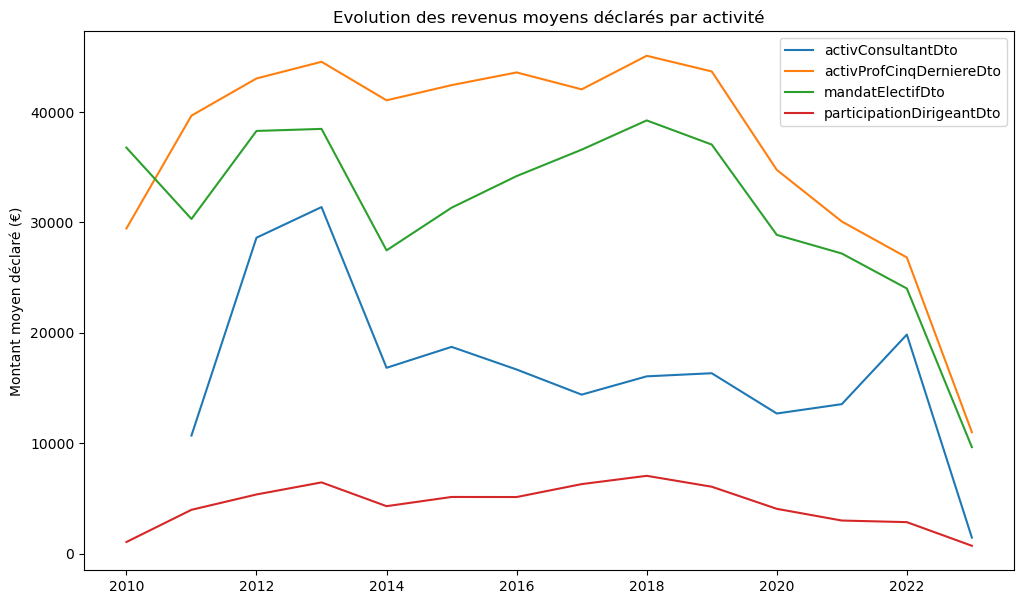

In [65]:
plt.figure(figsize=(12, 7))

sns.lineplot(data=mean_type_ressource_annee, x='annee', y='montant', hue='origine_ressource')

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.xlabel(None)
plt.ylabel('Montant moyen déclaré (€)')
plt.title("Evolution des revenus moyens déclarés par activité")

#### Variabilité des montants des déclarations, tous les montants

Text(0.5, 1.0, 'Variabilité des revenus déclarés par activité')

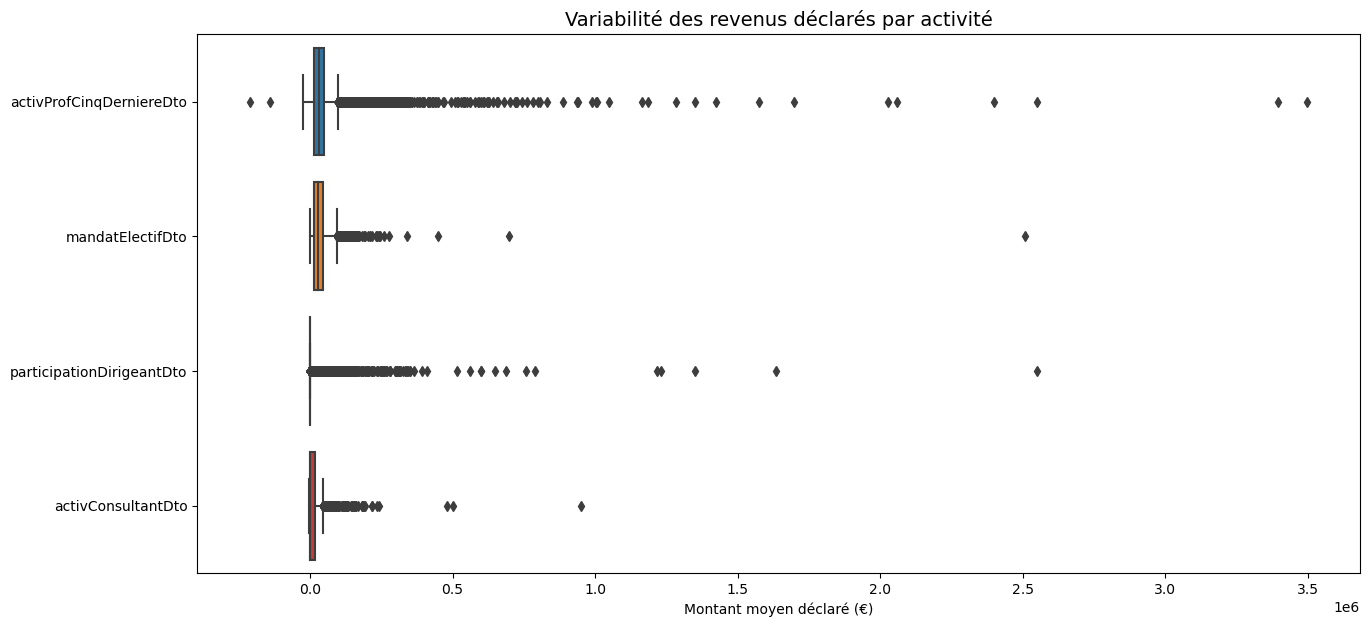

In [66]:
plt.figure(figsize=(15, 7))

sns.boxplot(data=data_group, y='origine_ressource', x='montant')

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par activité", size=14)

Moins de sens, ce qui suit en à plus.

### Variabilité des montants des déclarations par déclarant par origine ressources

1) Aggrégation par individus par activités par année en faisant la somme des montants déclarés pour chaque activités par année
2) Aggrégation par individus par activités en faisait la moyenne des année pour chaque activité

In [67]:
# aggrégation origine ressources pour chaque déclarant, moyenne par année pour chaque origine ressource
data_group_mean_origine = data_group.groupby(['id_individu', 'civilite', 'nom', 'prenom', 'qualite_mandat_label_type_mandat',
                            'origine_ressource'])[['montant']].mean().reset_index()

data_group_mean_origine.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,origine_ressource,montant
0,0,M.,ABAD,DAMIEN,Député,activProfCinqDerniereDto,"10,312.00"
1,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,"68,267.88"
2,0,M.,ABAD,DAMIEN,Député,participationDirigeantDto,0.00
3,1,Mme,ABADIE,CAROLINE,Député,mandatElectifDto,"60,071.67"
4,1,Mme,ABADIE,CAROLINE,Député,participationDirigeantDto,154.25


Text(0.5, 1.0, 'Variabilité des revenus déclarés par déclarant par activité avec les outliers')

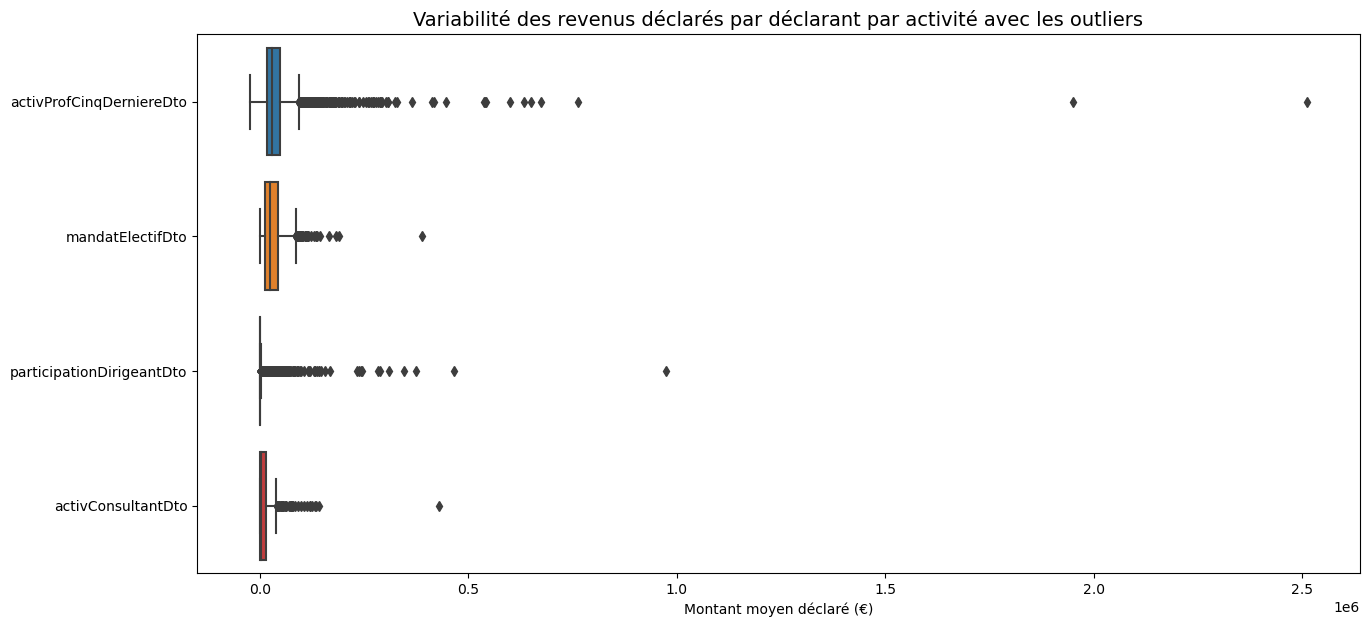

In [68]:
plt.figure(figsize=(15, 7))

sns.boxplot(data=data_group_mean_origine, y='origine_ressource', x='montant')

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par activité avec les outliers", size=14)

Text(0.5, 1.0, 'Variabilité des revenus déclarés par déclarant par activité sans les outliers')

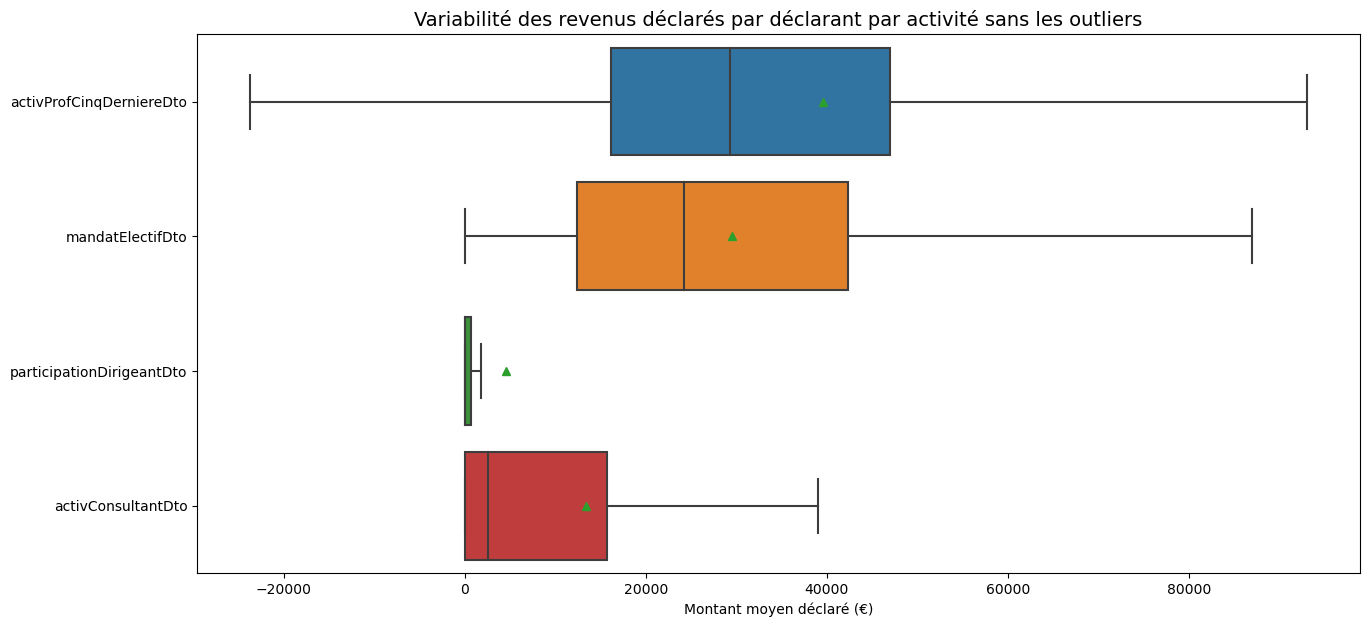

In [69]:
plt.figure(figsize=(15, 7))

sns.boxplot(data=data_group_mean_origine, y='origine_ressource', x='montant', showfliers=False, showmeans=True)

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par activité sans les outliers", size=14)

In [70]:
for activite in data_group_mean_origine['origine_ressource'].unique() : 
    moyenne_origine = (data_group_mean_origine.loc[data_group_mean_origine['origine_ressource']==activite, 'montant']).mean()
    print(f"Pour l'activité {activite}, la moyenne des revenus déclarés par déclarant était de {moyenne_origine.round(2)} €.")

Pour l'activité activProfCinqDerniereDto, la moyenne des revenus déclarés par déclarant était de 39581.81 €.
Pour l'activité mandatElectifDto, la moyenne des revenus déclarés par déclarant était de 29537.51 €.
Pour l'activité participationDirigeantDto, la moyenne des revenus déclarés par déclarant était de 4571.0 €.
Pour l'activité activConsultantDto, la moyenne des revenus déclarés par déclarant était de 13345.53 €.


In [71]:
data_group_mean_origine.groupby('origine_ressource')[['montant']].mean().sort_values('montant')

,montant
origine_ressource,
participationDirigeantDto,"4,571.00"
activConsultantDto,"13,345.53"
mandatElectifDto,"29,537.51"
activProfCinqDerniereDto,"39,581.81"


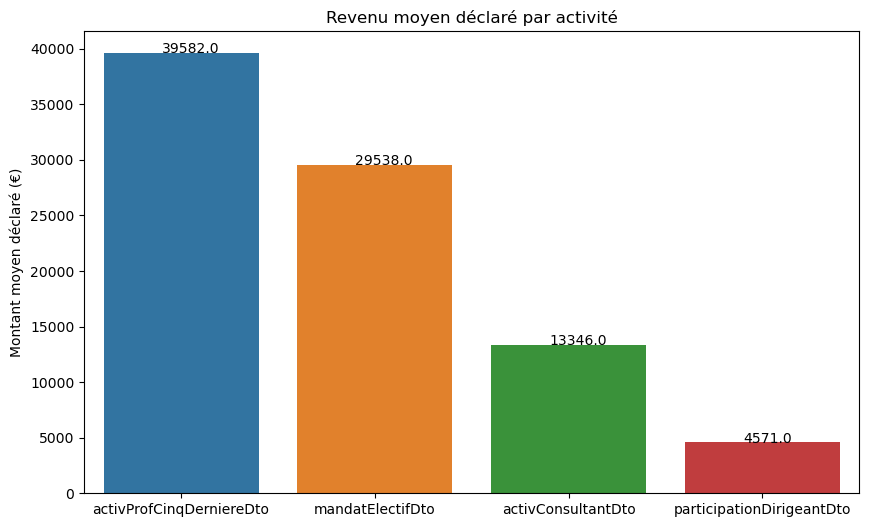

In [72]:
mean_type_ressource = data_group_mean_origine.groupby('origine_ressource')[['montant']].mean().sort_values('montant',
                                                                                                           ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_type_ressource, x='origine_ressource', y='montant')
plt.xlabel(None)
plt.ylabel('Montant moyen déclaré (€)')
plt.title("Revenu moyen déclaré par activité")

for i in range(mean_type_ressource.shape[0]):
    text = plt.text(i-0.1, mean_type_ressource['montant'].values[i], mean_type_ressource['montant'].values[i].round())

### Revenu Moyen par déclarant

1) Aggrégation par individus par activités par année en faisant la somme des montants déclarés pour chaque activités par année
2) Aggrégation par individus par activités en faisait la moyenne des année pour chaque activité
3) Aggrégation par individus en faisant la somme des activités

In [73]:
data_group_mean_origine

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,origine_ressource,montant
0,0,M.,ABAD,DAMIEN,Député,activProfCinqDerniereDto,"10,312.00"
1,0,M.,ABAD,DAMIEN,Député,mandatElectifDto,"68,267.88"
2,0,M.,ABAD,DAMIEN,Député,participationDirigeantDto,0.00
3,1,Mme,ABADIE,CAROLINE,Député,mandatElectifDto,"60,071.67"
4,1,Mme,ABADIE,CAROLINE,Député,participationDirigeantDto,154.25
...,...,...,...,...,...,...,...
13766,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,activProfCinqDerniereDto,"27,911.33"
13767,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,mandatElectifDto,"19,471.60"
13768,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,participationDirigeantDto,0.00
13769,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,activProfCinqDerniereDto,"130,357.00"


In [74]:
# moyenne des revenus déclarés par declarant au global
data_group_mean_individu = data_group_mean_origine.groupby(['id_individu', 'civilite', 'nom', 'prenom',
                                                            'qualite_mandat_label_type_mandat'])[['montant']].sum().reset_index()
data_group_mean_individu

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant
0,0,M.,ABAD,DAMIEN,Député,"78,579.88"
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92"
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00"
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29"
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78"
...,...,...,...,...,...,...
5814,5864,M.,YVON,RICHARD,Type mandat manquant,"116,020.43"
5815,5865,M.,ZANARDO,JACKY,Elu départemental,"84,265.14"
5816,5866,M.,ZEDET,CHRISTIAN,Membre d’EPCI,"71,819.83"
5817,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,"47,382.93"


In [75]:
print(f"Le revenu moyen déclaré par déclarant est de {data_group_mean_individu['montant'].mean().round()} €")
print(f"Le revenu médian déclaré par déclarant est de {data_group_mean_individu['montant'].round().median()} €")

Le revenu moyen déclaré par déclarant est de 58438.0 €
Le revenu médian déclaré par déclarant est de 48288.0 €


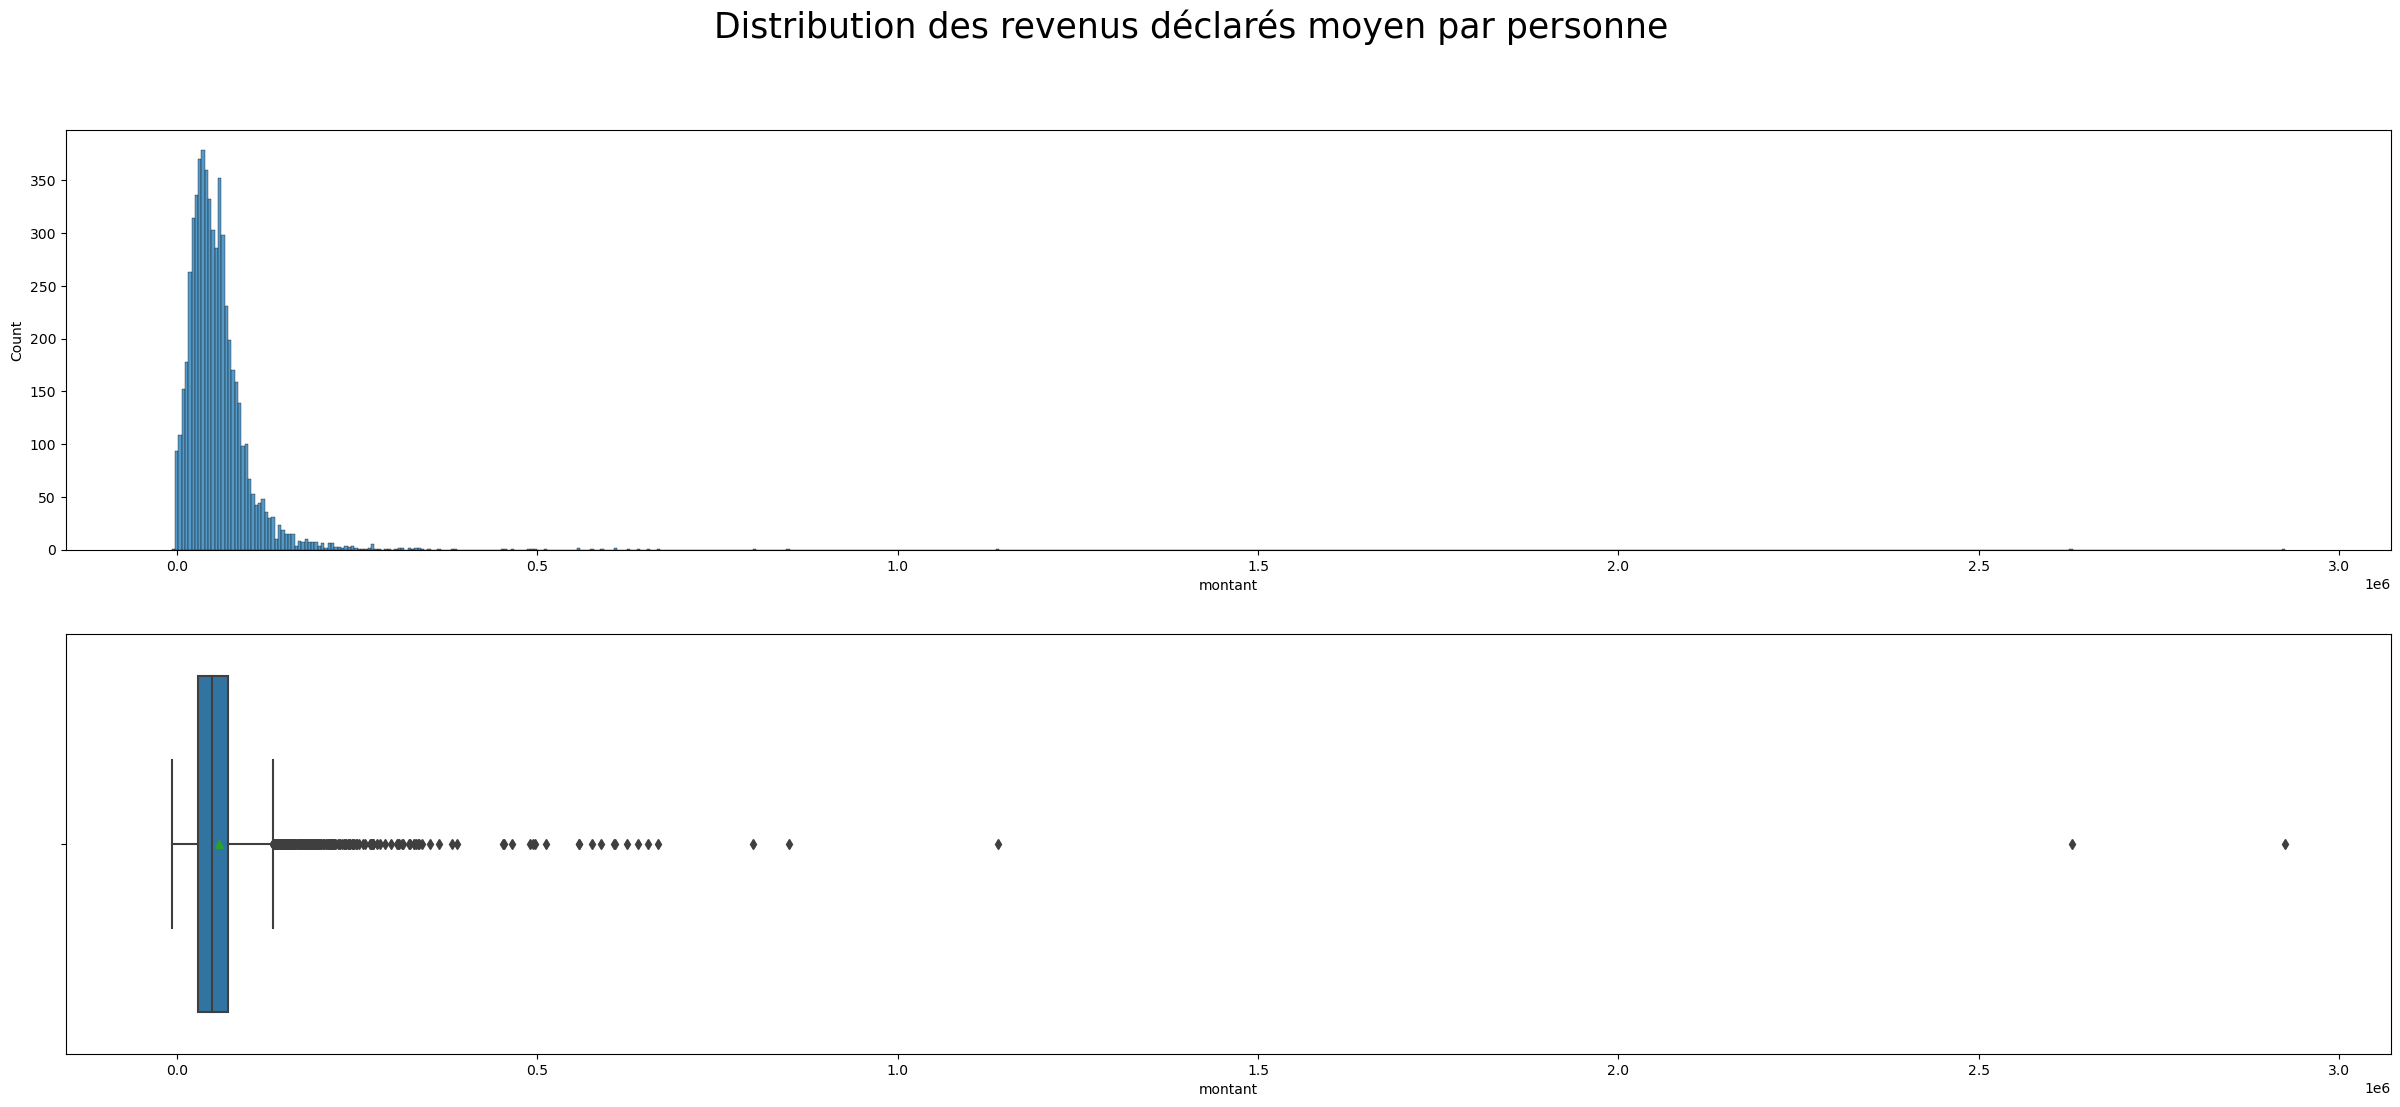

In [76]:
plt.figure(figsize=(30,12))

plt.suptitle("Distribution des revenus déclarés moyen par personne", size=25)

plt.subplot(2, 1, 1)
sns.histplot(data=data_group_mean_individu, x=data_group_mean_individu['montant'])

plt.subplot(2, 1, 2)
sns.boxplot(data=data_group_mean_individu, x=data_group_mean_individu['montant'], showmeans=True);

### Top revenu moyen

In [77]:
data_group_mean_individu['montant'].mean()

58437.95121720759

In [78]:
data_group_mean_individu.sort_values('montant', ascending=False).head(150)

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant
3768,3796,Mme,NAISSELINE,OMAYRA,Collectivité à statut particulier,"2,925,000.00"
4442,4478,M.,RICHIER,JACQUES,Membre d’EPCI,"2,628,543.83"
5653,5701,Mme,PANOSYAN-BOUVET,ASTRID,Député,"1,138,705.60"
1598,1613,M.,DUPOND-MORETTI,ERIC,Membre du Gouvernement,"848,934.57"
2667,2689,M.,JAMET,MARC-ANTOINE,Membre d’EPCI,"799,763.20"
3764,3792,M.,NOUVELOT,CEDRIC,Elu départemental,"667,646.90"
807,815,M.,BOUILLE,JEAN-PHILIPPE,Maire ou adjoint municipal,"653,008.25"
654,662,M.,BAROIN,FRANCOIS,Maire ou adjoint municipal,"640,075.65"
5199,5241,M.,APPARU,BENOIST,Maire ou adjoint municipal,"624,808.86"
1159,1168,M.,COUTIERE,DOMINIQUE,Elu départemental,"608,220.43"


In [79]:
# doublons nom prenom a cause de date de naissance differente
doublons_homonymes = data_group_mean_individu[data_group_mean_individu.duplicated(subset=['nom',
                                                                                          'prenom'], keep=False)].sort_values('nom')
pd.merge(doublons_homonymes, declarations[['id_individu', 'type_declaration_id',
                                          'type_declaration_label', 'qualite_declarant_for_p_d_f']], how='left', on='id_individu')
doublons_homonymes

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant
471,477,M.,BONNEAU,FRANCOIS,Sénateur,"77,982.43"
472,478,M.,BONNEAU,FRANCOIS,Elu régional,"49,531.83"
557,563,M.,BOYER,JEAN-MARC,Sénateur,"80,002.67"
558,564,M.,BOYER,JEAN-MARC,Elu départemental,"42,047.83"
1981,1999,M.,FONTAINE,MICHEL,Membre d’EPCI,"194,501.20"
1983,2001,M.,FONTAINE,MICHEL,Membre d’EPCI,0.00
2274,2294,Mme,GARNIER,CHRISTINE,Maire ou adjoint municipal,"24,989.62"
2277,2297,Mme,GARNIER,CHRISTINE,Membre d’EPCI,"26,274.43"
2148,2168,M.,GONZALEZ,JOSE,Député,0.00
2337,2357,M.,GONZALEZ,JOSE,Elu départemental,"20,858.57"


In [80]:
individus[individus.duplicated(subset=['nom', 'prenom'], keep=False)].sort_values('nom')

,id_individu,civilite,code_postal,complement,date_naissance,email,nom,pays,prenom,telephone_dec,ville,voie,annee_naissance
702,477,M.,[Données non publiées],[Données non publiées],08/02/1958,[Données non publiées],BONNEAU,[Données non publiées],FRANCOIS,[Données non publiées],[Données non publiées],[Données non publiées],1958
2115,478,M.,[Données non publiées],[Données non publiées],12/10/1953,[Données non publiées],BONNEAU,[Données non publiées],FRANCOIS,[Données non publiées],[Données non publiées],[Données non publiées],1953
5569,564,M.,[Données non publiées],[Données non publiées],26/03/1964,[Données non publiées],BOYER,[Données non publiées],JEAN-MARC,[Données non publiées],[Données non publiées],[Données non publiées],1964
5082,563,M.,[Données non publiées],[Données non publiées],24/02/1954,[Données non publiées],BOYER,[Données non publiées],JEAN-MARC,[Données non publiées],[Données non publiées],[Données non publiées],1954
4019,1999,M.,[Données non publiées],[Données non publiées],06/05/1952,[Données non publiées],FONTAINE,[Données non publiées],MICHEL,[Données non publiées],[Données non publiées],[Données non publiées],1952
3064,2001,M.,[Données non publiées],[Données non publiées],08/01/1949,[Données non publiées],FONTAINE,[Données non publiées],MICHEL,[Données non publiées],[Données non publiées],[Données non publiées],1949
5556,2294,Mme,[Données non publiées],[Données non publiées],29/10/1961,[Données non publiées],GARNIER,[Données non publiées],CHRISTINE,[Données non publiées],[Données non publiées],[Données non publiées],1961
3034,2297,Mme,[Données non publiées],[Données non publiées],01/11/1956,[Données non publiées],GARNIER,[Données non publiées],CHRISTINE,[Données non publiées],[Données non publiées],[Données non publiées],1956
4577,2357,M.,[Données non publiées],[Données non publiées],19/08/1941,[Données non publiées],GONZALEZ,[Données non publiées],JOSE,[Données non publiées],[Données non publiées],[Données non publiées],1941
49,2168,M.,[Données non publiées],[Données non publiées],28/04/1943,[Données non publiées],GONZALEZ,[Données non publiées],JOSE,[Données non publiées],[Données non publiées],[Données non publiées],1943


### Revenus par type de mandat

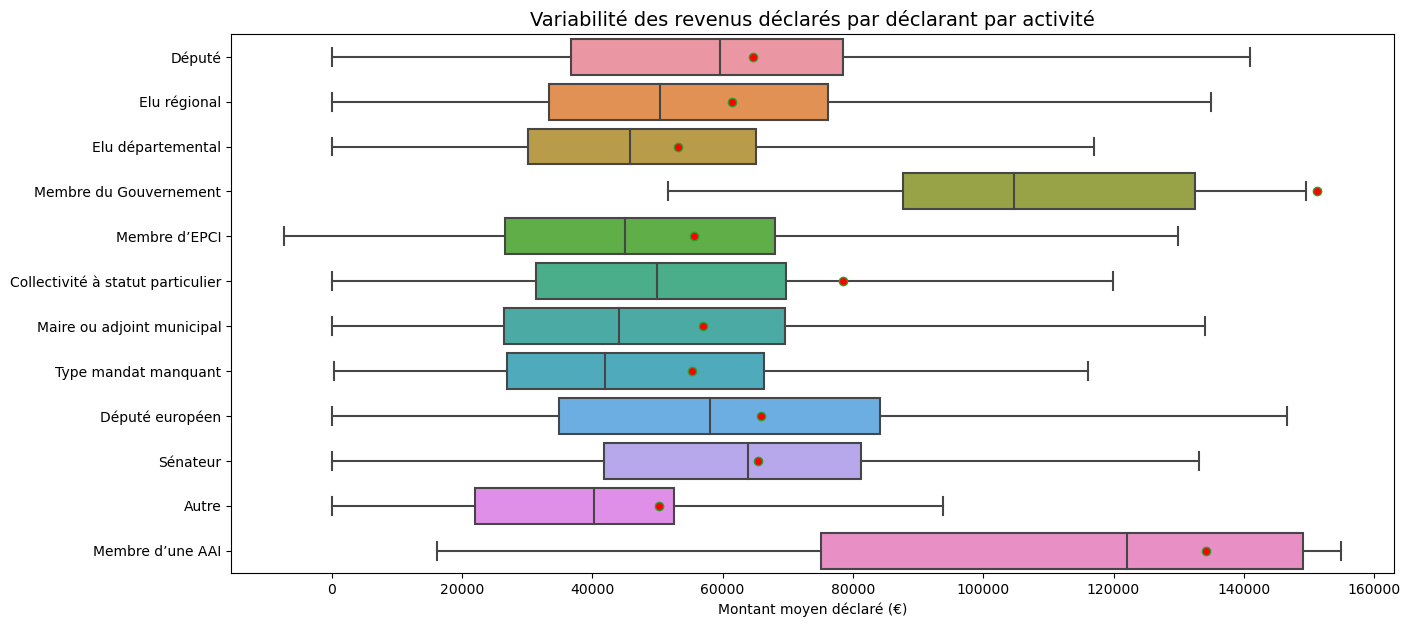

In [81]:
plt.figure(figsize=(15, 7))

meanprops = {'marker':'o', 'markerfacecolor':'red'}

sns.boxplot(data=data_group_mean_individu, y='qualite_mandat_label_type_mandat', x='montant',
            showfliers=False, showmeans=True, meanprops=meanprops)

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par activité", size=14);

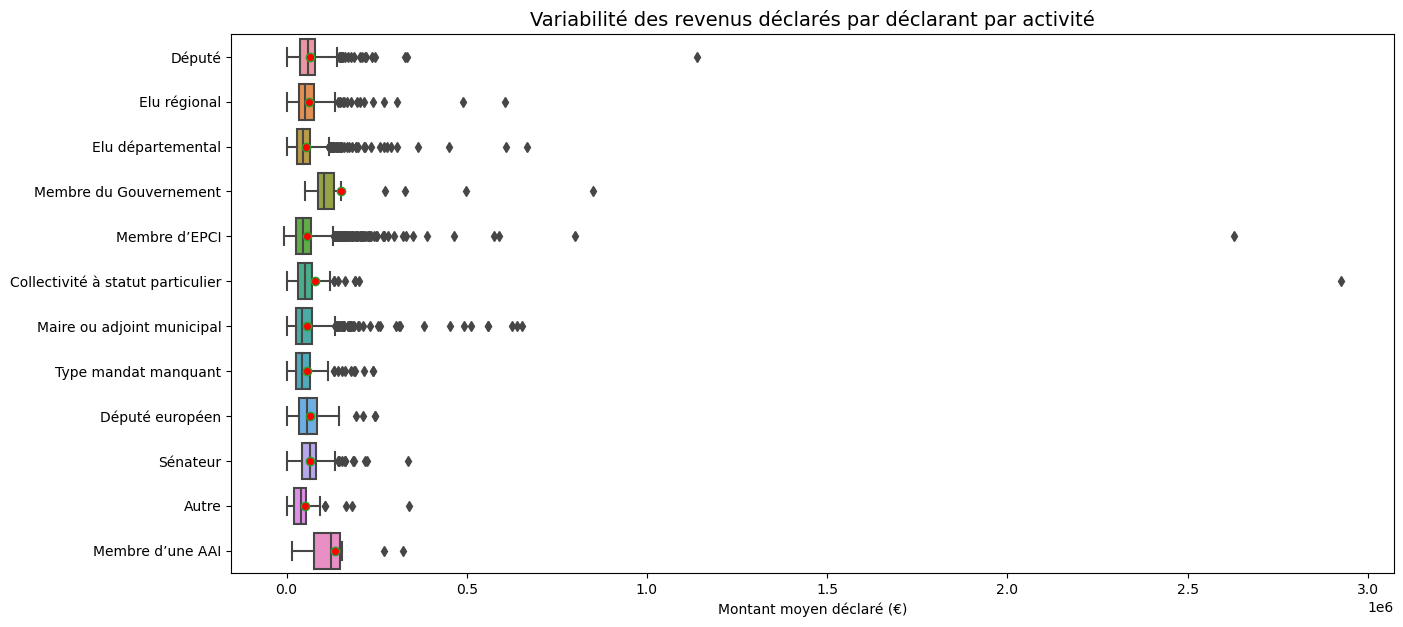

In [82]:
plt.figure(figsize=(15, 7))

meanprops = {'marker':'o', 'markerfacecolor':'red'}

sns.boxplot(data=data_group_mean_individu, y='qualite_mandat_label_type_mandat', x='montant',
            showmeans=True, meanprops=meanprops)

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par activité", size=14);

### Evolution des revenus moyen

In [83]:
# salaires déclarés globaux par année par individus
data_group_annee = data_group.groupby(['id_individu', 'civilite', 'nom', 'prenom', 'qualite_mandat_label_type_mandat',
                    'annee'])['montant'].sum().reset_index()
data_group_annee
#data_group_annee.groupby('id_individu')['montant'].sum()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,annee,montant
0,0,M.,ABAD,DAMIEN,Député,2015,"16,865.00"
1,0,M.,ABAD,DAMIEN,Député,2016,"23,035.00"
2,0,M.,ABAD,DAMIEN,Député,2017,"115,174.00"
3,0,M.,ABAD,DAMIEN,Député,2018,"95,243.00"
4,0,M.,ABAD,DAMIEN,Député,2019,"87,491.00"
...,...,...,...,...,...,...,...
40695,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,2017,"125,907.00"
40696,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,2018,"145,511.00"
40697,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,2019,"165,731.00"
40698,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,2020,"120,000.00"


Text(0.5, 1.0, 'Variabilité des revenus déclarés par déclarant par année')

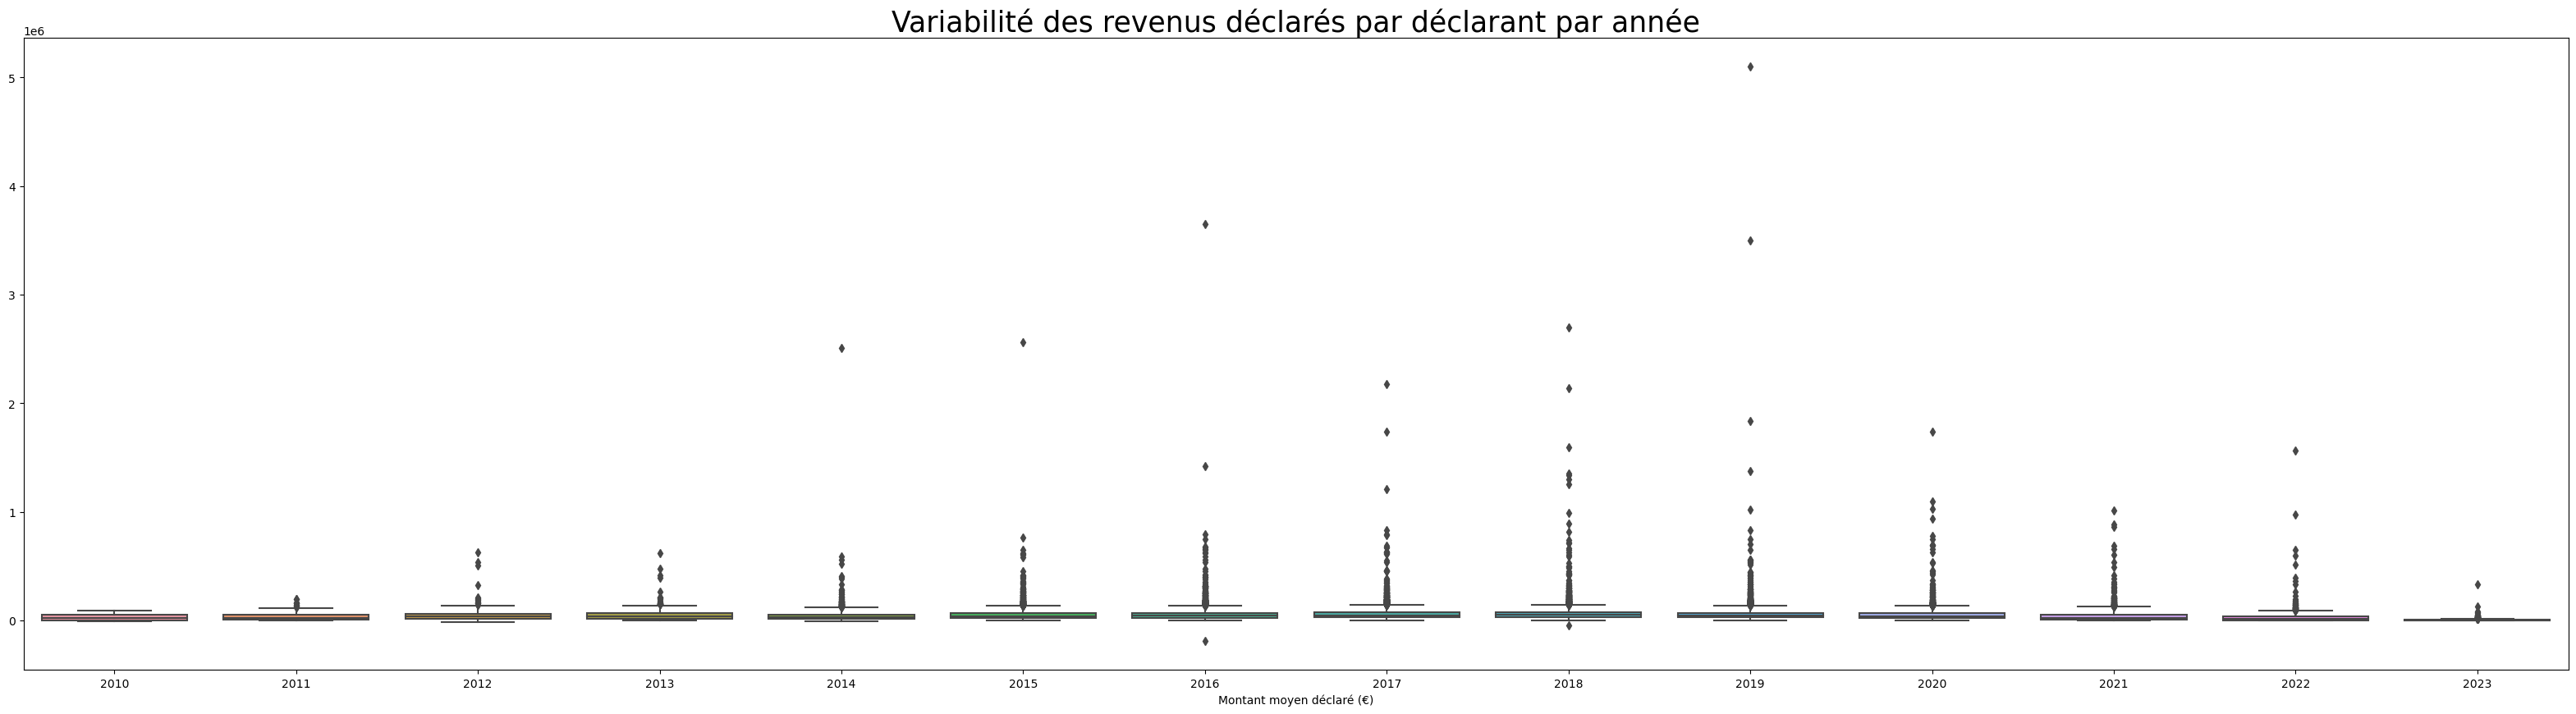

In [84]:
plt.figure(figsize=(40, 10))

sns.boxplot(data=data_group_annee, x='annee', y='montant')

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par année", size=25)

Text(0.5, 1.0, 'Variabilité des revenus déclarés par déclarant par année sans les outliers')

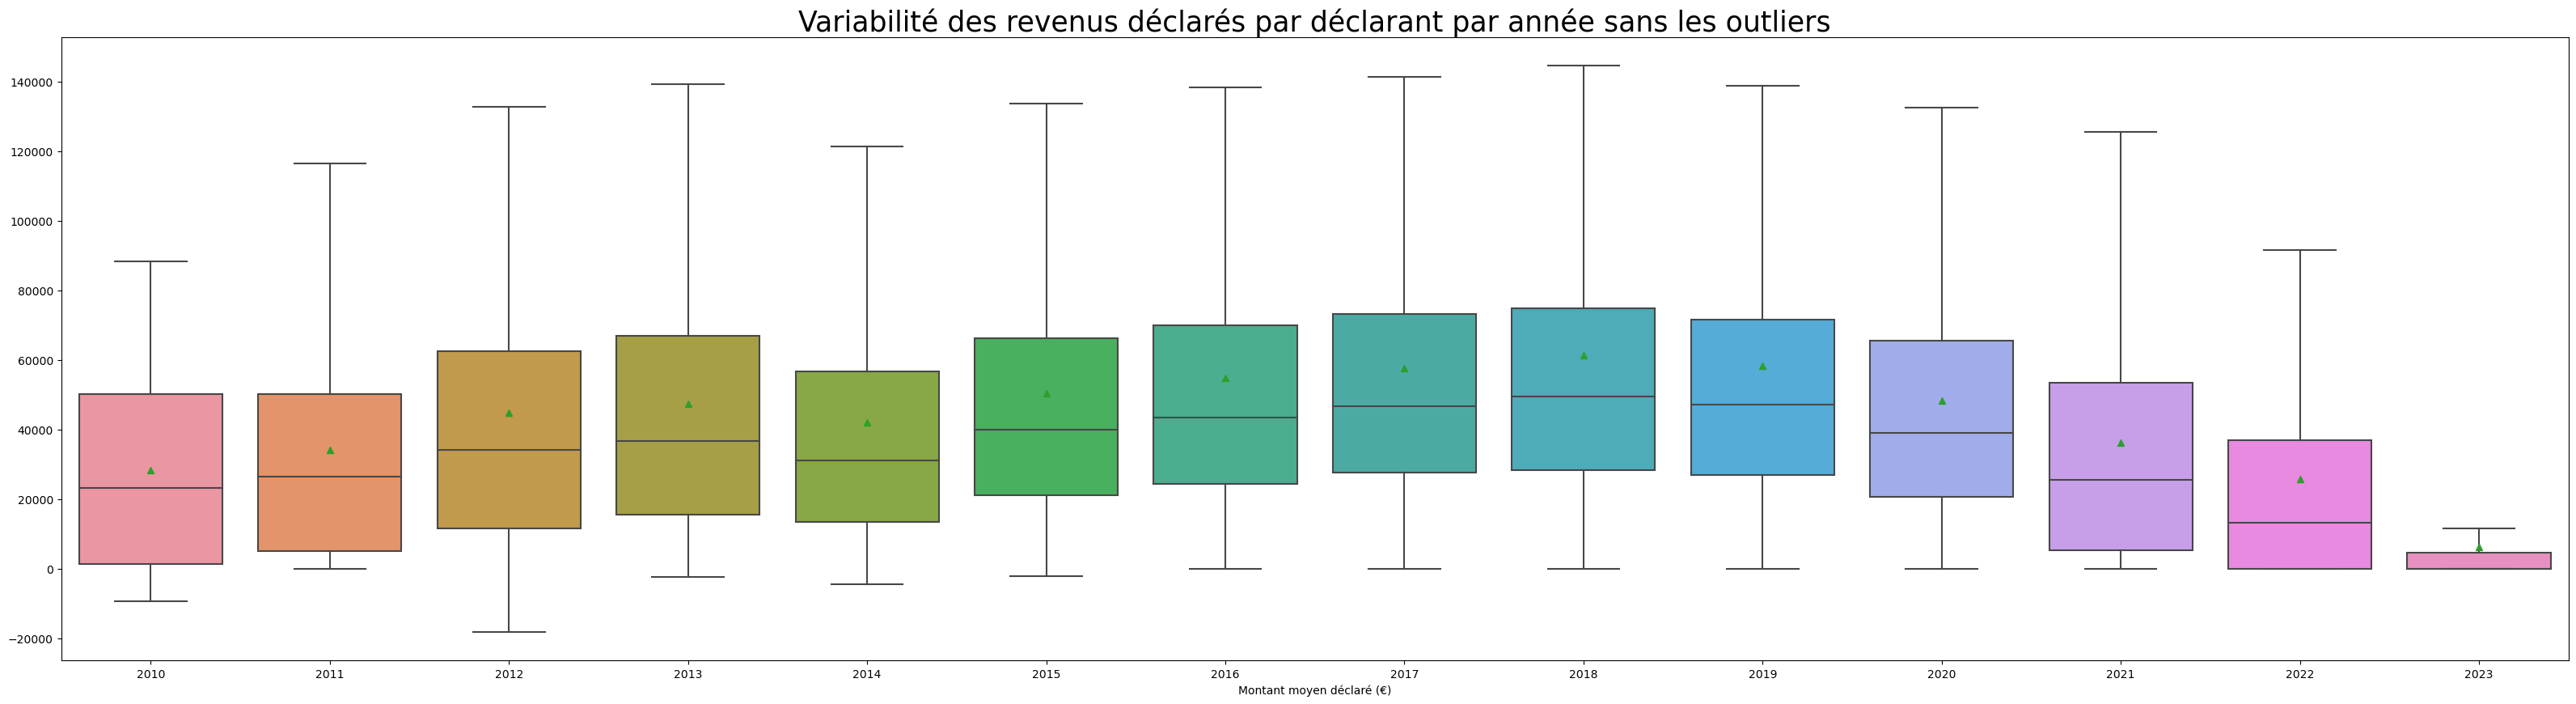

In [85]:
plt.figure(figsize=(40, 10))

sns.boxplot(data=data_group_annee, x='annee', y='montant', showfliers=False, showmeans=True)

plt.ylabel(None)
plt.xlabel('Montant moyen déclaré (€)')
plt.title("Variabilité des revenus déclarés par déclarant par année sans les outliers", size=25)

In [86]:
for annee in data_group_annee['annee'].sort_values().unique() : 
    moyenne_annee = (data_group_annee.loc[data_group_annee['annee']==annee, 'montant']).mean()
    print(f"En {annee}, la moyenne des revenus déclarés par déclarant était de {moyenne_annee.round(2)} €.")

En 2010, la moyenne des revenus déclarés par déclarant était de 28485.73 €.
En 2011, la moyenne des revenus déclarés par déclarant était de 34366.64 €.
En 2012, la moyenne des revenus déclarés par déclarant était de 44939.54 €.
En 2013, la moyenne des revenus déclarés par déclarant était de 47482.09 €.
En 2014, la moyenne des revenus déclarés par déclarant était de 42118.33 €.
En 2015, la moyenne des revenus déclarés par déclarant était de 50612.39 €.
En 2016, la moyenne des revenus déclarés par déclarant était de 54915.52 €.
En 2017, la moyenne des revenus déclarés par déclarant était de 57822.03 €.
En 2018, la moyenne des revenus déclarés par déclarant était de 61521.0 €.
En 2019, la moyenne des revenus déclarés par déclarant était de 58436.41 €.
En 2020, la moyenne des revenus déclarés par déclarant était de 48409.72 €.
En 2021, la moyenne des revenus déclarés par déclarant était de 36283.66 €.
En 2022, la moyenne des revenus déclarés par déclarant était de 25869.41 €.
En 2023, la m

### Cumul des sources de revenus

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204565 entries, 0 to 204566
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_declaration                        204565 non-null  int64  
 1   id_individu                           204565 non-null  int64  
 2   date_depot                            204565 non-null  object 
 3   type_declaration_label                204565 non-null  object 
 4   type_declaration_id                   204565 non-null  object 
 5   qualite_mandat_label_type_mandat      204565 non-null  object 
 6   qualite_mandat_nom_categorie_mandat   204565 non-null  object 
 7   civilite                              204565 non-null  object 
 8   date_naissance                        204565 non-null  object 
 9   nom                                   204565 non-null  object 
 10  prenom                                204565 non-null  object 
 11  

In [88]:
colonne_individu = ['id_individu', 'qualite_mandat_label_type_mandat', 'civilite', 'nom', 'prenom', 'annee']
colonne_individu2 = ['id_individu', 'qualite_mandat_label_type_mandat', 'civilite', 'nom', 'prenom', 'origine_ressource','id_activite', 'annee', 'montant']

In [89]:
activites_payees = data[data['montant']>0]
activites_payees.shape

(88525, 20)

In [90]:
data[colonne_individu2]

,id_individu,qualite_mandat_label_type_mandat,civilite,nom,prenom,origine_ressource,id_activite,annee,montant
0,0,Député,M.,ABAD,DAMIEN,mandatElectifDto,m8,2021,"16,384.00"
1,0,Député,M.,ABAD,DAMIEN,mandatElectifDto,m8,2022,"6,827.00"
2,0,Député,M.,ABAD,DAMIEN,mandatElectifDto,m9,2017,0.00
3,0,Député,M.,ABAD,DAMIEN,mandatElectifDto,m9,2018,0.00
4,0,Député,M.,ABAD,DAMIEN,mandatElectifDto,m9,2019,0.00
...,...,...,...,...,...,...,...,...,...
204562,5868,Maire ou adjoint municipal,M.,ZUILI,NICOLAS,participationDirigeantDto,d52217,2020,0.00
204563,5868,Maire ou adjoint municipal,M.,ZUILI,NICOLAS,participationDirigeantDto,d52216,2021,0.00
204564,5868,Maire ou adjoint municipal,M.,ZUILI,NICOLAS,participationDirigeantDto,d52216,2020,0.00
204565,5868,Maire ou adjoint municipal,M.,ZUILI,NICOLAS,activProfCinqDerniereDto,p13449,2016,"112,534.00"


In [91]:
# nombre activités payés
nombre_activites_payees = activites_payees.groupby(colonne_individu)[['id_activite']].count().reset_index().sort_values('id_activite', ascending=False)
nombre_activites_payees.head()

,id_individu,qualite_mandat_label_type_mandat,civilite,nom,prenom,annee,id_activite
26166,4100,Maire ou adjoint municipal,Mme,PULVAR,AUDREY,2019,27
5985,931,Elu régional,Mme,CARCHON,SEVERINE,2021,16
5984,931,Elu régional,Mme,CARCHON,SEVERINE,2020,15
28597,4482,Maire ou adjoint municipal,Mme,RIFFAUD,SAMIA,2020,15
20130,3163,Maire ou adjoint municipal,M.,LECLERC,SEBASTIEN,2014,14


In [92]:
nombre_activites_payees2 = pd.merge(nombre_activites_payees,
                                   data_group_annee[['id_individu','annee' , 'montant']], on=['id_individu', 'annee'], how='inner')
nombre_activites_payees2

,id_individu,qualite_mandat_label_type_mandat,civilite,nom,prenom,annee,id_activite,montant
0,4100,Maire ou adjoint municipal,Mme,PULVAR,AUDREY,2019,27,"131,597.00"
1,931,Elu régional,Mme,CARCHON,SEVERINE,2021,16,"43,516.00"
2,931,Elu régional,Mme,CARCHON,SEVERINE,2020,15,"28,701.00"
3,4482,Maire ou adjoint municipal,Mme,RIFFAUD,SAMIA,2020,15,"332,415.00"
4,3163,Maire ou adjoint municipal,M.,LECLERC,SEBASTIEN,2014,14,"146,160.00"
...,...,...,...,...,...,...,...,...
37438,2958,Député,M.,LEFEVRE,MATHIEU,2015,1,"63,521.00"
37439,2958,Député,M.,LEFEVRE,MATHIEU,2014,1,"57,586.00"
37440,2958,Député,M.,LEFEVRE,MATHIEU,2013,1,"54,119.00"
37441,2958,Député,M.,LEFEVRE,MATHIEU,2012,1,"47,860.00"


In [93]:
# individus declarant + de 100 000€ par an réparti sur + de 5 activités
individus_activites_importants = nombre_activites_payees2[(nombre_activites_payees2['id_activite']>5)&
                         (nombre_activites_payees2['montant']>100000)].sort_values('montant', ascending=False)
individus_activites_importants

,id_individu,qualite_mandat_label_type_mandat,civilite,nom,prenom,annee,id_activite,montant
48,1613,Membre du Gouvernement,M.,DUPOND-MORETTI,ERIC,2019,10,"1,834,400.00"
830,5310,Membre d’EPCI,M.,BRIAND,PHILIPPE,2018,6,"1,352,522.00"
46,1613,Membre du Gouvernement,M.,DUPOND-MORETTI,ERIC,2018,10,"1,301,878.00"
267,2689,Membre d’EPCI,M.,JAMET,MARC-ANTOINE,2019,7,"830,068.00"
926,2689,Membre d’EPCI,M.,JAMET,MARC-ANTOINE,2018,6,"815,436.00"
...,...,...,...,...,...,...,...,...
451,1496,Membre d’EPCI,M.,DESFOSSES,ALAIN,2014,7,"100,734.00"
529,3921,Elu départemental,M.,PELIEU,MICHEL,2018,6,"100,714.00"
260,4330,Elu départemental,M.,RICHARD,LAURENT,2021,7,"100,619.00"
723,12,Elu départemental,M.,ACCARY,ANDRE,2019,6,"100,258.00"


In [94]:
individus_activites_importants['qualite_mandat_label_type_mandat'].value_counts()

Membre d’EPCI                        132
Elu départemental                    109
Maire ou adjoint municipal            66
Elu régional                          39
Député                                24
Sénateur                              16
Autre                                  6
Collectivité à statut particulier      6
Membre du Gouvernement                 5
Député européen                        3
Name: qualite_mandat_label_type_mandat, dtype: int64

<Axes: xlabel='id_activite', ylabel='montant'>

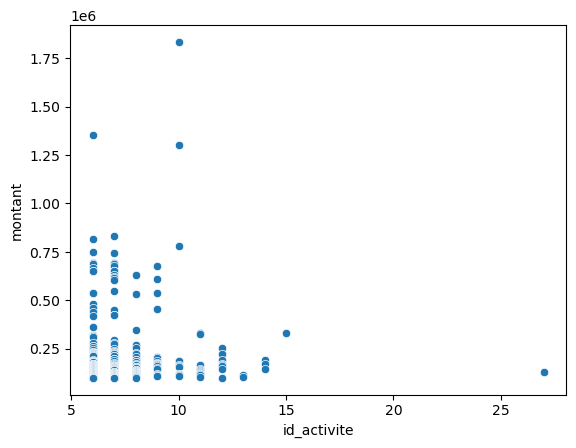

In [95]:
sns.scatterplot(data=individus_activites_importants, x='id_activite', y='montant')

### Distribution du nombre d'activités

<Axes: xlabel='id_activite', ylabel='Count'>

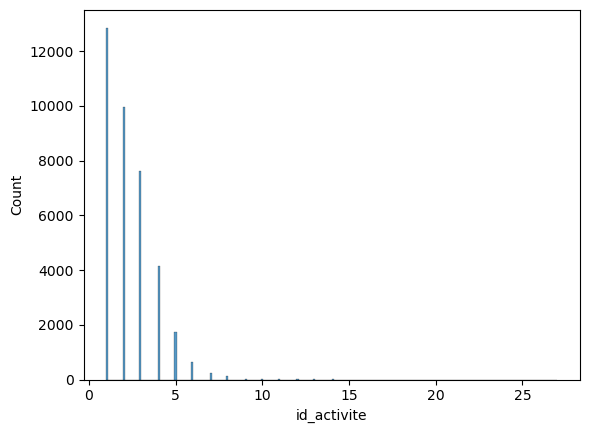

In [96]:
sns.histplot(nombre_activites_payees2['id_activite'])

## Analyse des participations financières

In [97]:
cle_individu_declaration = data[['id_individu', 'id_declaration']].drop_duplicates()
cle_individu_declaration.head()

,id_individu,id_declaration
0,0,10647
48,1,8289
62,2,7293
69,3,6865
127,4,1878


In [98]:
data_financiere = pd.merge(data_group_mean_individu, cle_individu_declaration, how='left', on='id_individu')
data_financiere.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,id_declaration
0,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92",8289
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",7293
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29",6865
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",1878


In [99]:
data_financiere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819 entries, 0 to 5818
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_individu                       5819 non-null   int64  
 1   civilite                          5819 non-null   object 
 2   nom                               5819 non-null   object 
 3   prenom                            5819 non-null   object 
 4   qualite_mandat_label_type_mandat  5819 non-null   object 
 5   montant                           5819 non-null   float64
 6   id_declaration                    5819 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 363.7+ KB


In [100]:
participationFinanciereDto.head()

,id_declaration,id_participation_financiere_dto,acti_conseil,capital_detenu,commentaire,evaluation,id,label,nom_organisation_conseil,nom_societe,nombre_parts,remuneration
0,3,4154,Non,NaN,NaN,12200,CREATION,NaN,NaN,PLURIEL VALEURS 4,151.00,9097.14 €
1,3,4155,Non,NaN,NaN,4047,CREATION,NaN,NaN,NOUVELLES PARTS SOCIALES B,"4,047.00",47 €
2,5,2703,NaN,NaN,NaN,1200,CREATION,NaN,NaN,LA COOPERATIVE TIERS-LIEUX,24.00,parts sociales de scic non rémunérées
3,5,2704,NaN,NaN,NaN,2400,CREATION,NaN,NaN,COOP'ALPHA,48.00,parts sociales de Scop SA non rémunérées
4,7,3362,NaN,5.00,Il s'agit d'une SCI immobilière qui loue le bi...,9600,CREATION,NaN,NaN,SCI,21.00,88 € en 2020. Environ 600 à 700 € en 2021.


In [101]:
data_financiere_brute = participationFinanciereDto[['id_declaration', 'id_participation_financiere_dto', 'nom_societe', 'evaluation']]
data_financiere_brute

,id_declaration,id_participation_financiere_dto,nom_societe,evaluation
0,3,4154,PLURIEL VALEURS 4,12200
1,3,4155,NOUVELLES PARTS SOCIALES B,4047
2,5,2703,LA COOPERATIVE TIERS-LIEUX,1200
3,5,2704,COOP'ALPHA,2400
4,7,3362,SCI,9600
...,...,...,...,...
10983,10871,967,SARL AGENCE TOUS TRAVAUX,5841
10984,10871,969,SAS KARMAN,10
10985,10871,965,EURL AIXPERTS ASSOCIES,375000
10986,10871,966,SAS ALTGR,13392


In [102]:
data_financiere = pd.merge(data_financiere, data_financiere_brute, how='inner', on='id_declaration')
data_financiere

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,id_declaration,id_participation_financiere_dto,nom_societe,evaluation
0,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,6,AIRBUS,1929
1,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,4,ORANGE,877
2,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,5,CREDIT AGRICOLE SA,2910
3,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,7,L'OREAL,6552
4,1,Mme,ABADIE,CAROLINE,Député,"60,225.92",8289,10,SCI,296100
...,...,...,...,...,...,...,...,...,...,...
6153,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,"130,357.00",1077,10969,ORANGE,2875
6154,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,"130,357.00",1077,10970,SOCIETE GENERALE,10182
6155,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,"130,357.00",1077,10971,STELLANTIS,8880
6156,5868,M.,ZUILI,NICOLAS,Maire ou adjoint municipal,"130,357.00",1077,10972,SUEZ,8000


In [103]:
# creation nom société nettoyé
data_financiere['nom_societe_nettoye'] = data_financiere['nom_societe'].apply(modif_champs_societe)

data_financiere.loc[data_financiere['nom_societe_nettoye']=='', 'nom_societe_nettoye'] = '[Données non publiées]'

data_financiere.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,id_declaration,id_participation_financiere_dto,nom_societe,evaluation,nom_societe_nettoye
0,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,6,AIRBUS,1929,AIRBUS
1,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,4,ORANGE,877,ORANGE
2,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,5,CREDIT AGRICOLE SA,2910,CREDIT AGRICOLE SA
3,0,M.,ABAD,DAMIEN,Député,"78,579.88",10647,7,L'OREAL,6552,L'OREAL
4,1,Mme,ABADIE,CAROLINE,Député,"60,225.92",8289,10,SCI,296100,SCI


In [104]:
data_financiere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6158 entries, 0 to 6157
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_individu                       6158 non-null   int64  
 1   civilite                          6158 non-null   object 
 2   nom                               6158 non-null   object 
 3   prenom                            6158 non-null   object 
 4   qualite_mandat_label_type_mandat  6158 non-null   object 
 5   montant                           6158 non-null   float64
 6   id_declaration                    6158 non-null   int64  
 7   id_participation_financiere_dto   6158 non-null   int64  
 8   nom_societe                       6158 non-null   object 
 9   evaluation                        6158 non-null   int64  
 10  nom_societe_nettoye               6158 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 577.3+ KB


### Top 20 participation financière des déclarants

In [105]:
data_financiere_top = data_financiere.groupby('nom_societe_nettoye')[['evaluation']].agg(['count',
                                                                    'sum']).sort_values(('evaluation',
                                                                                           'count'), ascending=False).reset_index()
data_financiere_top.columns = ['Société', 'Nombre de déclarants', 'Valeur boursière']

data_financiere_top.head(12)

,Société,Nombre de déclarants,Valeur boursière
0,SCI,1354,184250351
1,[Données non publiées],165,37586641
2,CREDIT AGRICOLE,119,767568
3,ORANGE,69,353383
4,AIR LIQUIDE,65,2663316
5,ENGIE,63,410975
6,GFA,56,6901193
7,SARL,51,14795167
8,AXA,49,3361327
9,SANOFI,48,895650


In [106]:
data_financiere_top.sort_values('Valeur boursière', ascending=False).head(100)

,Société,Nombre de déclarants,Valeur boursière
577,SAS ARCHE,1,300000000
2248,GROUPE INDUSTRIEL MARCEL DASSAULT,1,187698139
0,SCI,1354,184250351
2251,HDH,1,170639217
838,ROND POINT IMMOBILIER,1,159950589
2261,HABERT DASSAULT FINANCES,1,96111803
834,RD INVESTISSEMENTS,1,84364000
1161,SCDC,1,68903000
1,[Données non publiées],165,37586641
1880,CIE DU CATAMARAN,1,35000000


### Participation financière par individus

In [107]:
montant_participation_financiere = data_financiere.groupby('id_individu')[['evaluation']].sum().rename(columns={'evaluation' : 'montant_participation_financiere'}).reset_index()
montant_participation_financiere

,id_individu,montant_participation_financiere
0,0,12268
1,1,299100
2,3,4848
3,6,350
4,9,11200
...,...,...
1874,5862,2397
1875,5863,2000
1876,5864,15405
1877,5867,759673


In [108]:
data_individus_agg = pd.merge(data_group_mean_individu, montant_participation_financiere, on='id_individu', how='left')
data_individus_agg

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,montant_participation_financiere
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00"
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00"
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00"
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN
...,...,...,...,...,...,...,...
5814,5864,M.,YVON,RICHARD,Type mandat manquant,"116,020.43","15,405.00"
5815,5865,M.,ZANARDO,JACKY,Elu départemental,"84,265.14",NaN
5816,5866,M.,ZEDET,CHRISTIAN,Membre d’EPCI,"71,819.83",NaN
5817,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,"47,382.93","759,673.00"


In [109]:
data_individus_agg.sort_values('montant_participation_financiere', ascending=False).head(100)

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,montant_participation_financiere
2403,2424,M.,HABERT-DASSAULT,VICTOR,Député,"15,740.17","615,770,727.00"
5268,5310,M.,BRIAND,PHILIPPE,Membre d’EPCI,"465,622.95","345,582,691.00"
3893,3924,M.,PELLENC,ROGER,Maire ou adjoint municipal,"453,929.59","84,801,656.00"
1159,1168,M.,COUTIERE,DOMINIQUE,Elu départemental,"608,220.43","68,947,932.00"
3331,3356,M.,MARTIN,MICHEL,Membre d’EPCI,"281,681.80","48,186,644.00"
1992,2010,M.,FOUNTAINE,JEAN-FRANCOIS,Maire ou adjoint municipal,"79,714.29","35,000,000.00"
3532,3559,M.,MAILLARD,SYLVAIN,Député,"124,100.11","27,832,900.00"
4426,4461,Mme,RENAUD GARABEDIAN,EVELYNE,Sénateur,"25,700.00","26,500,907.00"
1966,1984,M.,FERRACCI,MARC,Député,"129,231.50","22,521,941.00"
1531,1546,M.,DOMINICI,JEAN BAPTISTE,Membre d’EPCI,"58,732.90","20,510,845.00"


In [110]:
# clé activité individu
cle_individu_activite = nombre_activites_payees2.groupby('id_individu')[['id_activite']].mean().rename(columns={'id_activite':'nombre_activites_payees_moyennes'}).reset_index()

In [111]:
data_individus_agg = pd.merge(data_individus_agg, cle_individu_activite, on='id_individu', how='left')
data_individus_agg.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant,montant_participation_financiere,nombre_activites_payees_moyennes
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00",2.00
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN,1.40
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00",4.00
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN,1.11


In [112]:
# renommage colonne montant
data_individus_agg = data_individus_agg.rename(columns={'montant':'montant_moyen_ressource'})

In [113]:
data_individus_agg.sort_values('montant_participation_financiere', ascending=False).head(100)

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes
2403,2424,M.,HABERT-DASSAULT,VICTOR,Député,"15,740.17","615,770,727.00",1.00
5268,5310,M.,BRIAND,PHILIPPE,Membre d’EPCI,"465,622.95","345,582,691.00",4.83
3893,3924,M.,PELLENC,ROGER,Maire ou adjoint municipal,"453,929.59","84,801,656.00",2.71
1159,1168,M.,COUTIERE,DOMINIQUE,Elu départemental,"608,220.43","68,947,932.00",6.71
3331,3356,M.,MARTIN,MICHEL,Membre d’EPCI,"281,681.80","48,186,644.00",10.00
1992,2010,M.,FOUNTAINE,JEAN-FRANCOIS,Maire ou adjoint municipal,"79,714.29","35,000,000.00",2.29
3532,3559,M.,MAILLARD,SYLVAIN,Député,"124,100.11","27,832,900.00",2.42
4426,4461,Mme,RENAUD GARABEDIAN,EVELYNE,Sénateur,"25,700.00","26,500,907.00",1.00
1966,1984,M.,FERRACCI,MARC,Député,"129,231.50","22,521,941.00",1.33
1531,1546,M.,DOMINICI,JEAN BAPTISTE,Membre d’EPCI,"58,732.90","20,510,845.00",2.00


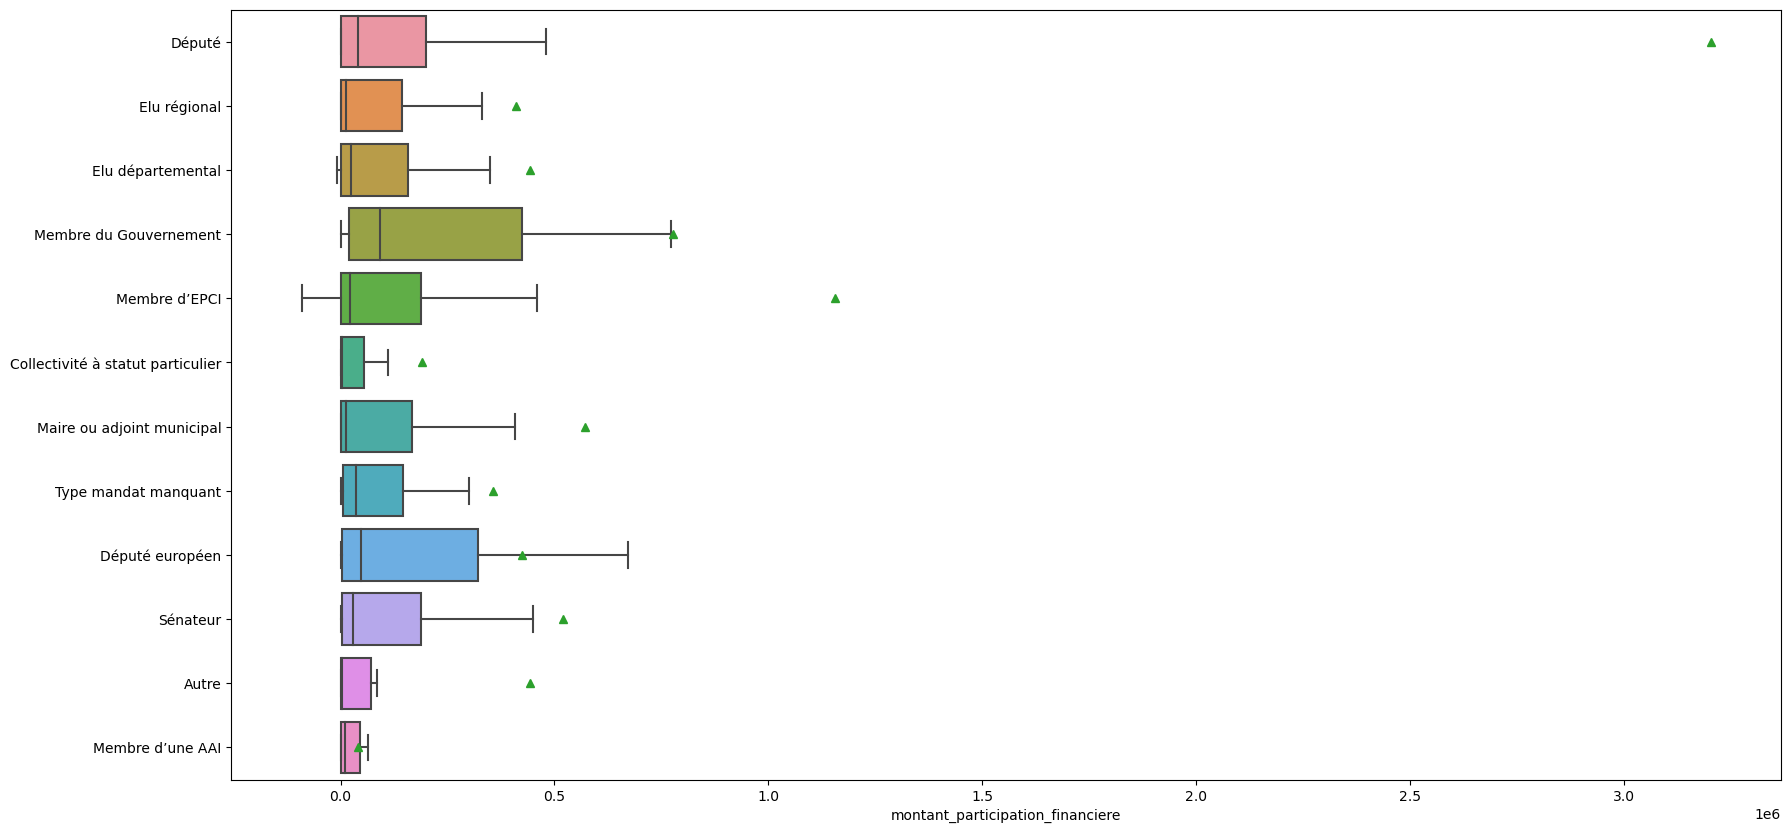

In [114]:
plt.figure(figsize=(20,10))

sns.boxplot(data=data_individus_agg, y='qualite_mandat_label_type_mandat', x='montant_participation_financiere',
            showfliers=False, showmeans=True)

plt.ylabel(None);

### Analyse des employeurs par activités

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204565 entries, 0 to 204566
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id_declaration                        204565 non-null  int64  
 1   id_individu                           204565 non-null  int64  
 2   date_depot                            204565 non-null  object 
 3   type_declaration_label                204565 non-null  object 
 4   type_declaration_id                   204565 non-null  object 
 5   qualite_mandat_label_type_mandat      204565 non-null  object 
 6   qualite_mandat_nom_categorie_mandat   204565 non-null  object 
 7   civilite                              204565 non-null  object 
 8   date_naissance                        204565 non-null  object 
 9   nom                                   204565 non-null  object 
 10  prenom                                204565 non-null  object 
 11  

In [116]:
data['employeur_activProfCinqDerniereDto'].value_counts()[:150]

EDUCATION NATIONALE                                 1656
PROFESSION LIBERALE                                  284
NEANT                                                258
ASSEMBLEE NATIONALE                                  212
[Données non publiées]                               204
MINISTERE DE L'EDUCATION NATIONALE                   162
SCEA                                                 127
RETRAITE                                             116
MOI MEME                                             115
POLE EMPLOI                                          106
MINISTERE DE L'INTERIEUR                             104
EARL                                                 103
GAEC                                                 101
MINISTERE EDUCATION NATIONALE                         98
ACTIVITE LIBERALE                                     96
LA POSTE                                              94
LIBERAL                                               89
ETAT                           

In [117]:
data['societe_participationDirigeantDto'].value_counts()[:150]

SCI                                                          4124
SDIS                                                          416
[Données non publiées]                                        280
CCAS                                                          266
PARTI SOCIALISTE                                              212
CAUE                                                          156
LES REPUBLICAINS                                              155
SCEA                                                          141
MISSION LOCALE                                                128
SARL                                                          124
CENTRE COMMUNAL D'ACTION SOCIALE                              117
NEANT                                                         116
CONSEIL DEPARTEMENTAL                                         115
ADIL                                                          105
RASSEMBLEMENT NATIONAL                                        101
GFA       

In [118]:
data['employeur_activConsultantDto'].value_counts()[:150]

NEANT                                                  272
AUTO-ENTREPRENEUR                                       89
AUTOENTREPRENEUR                                        69
AUTO ENTREPRENEUR                                       68
[Données non publiées]                                  50
0                                                       35
AUTO ENTREPRISE                                         31
AUTO-ENTREPRISE                                         27
CNFPT                                                   22
ENTREPRENEUR INDIVIDUEL                                 20
ENTREPRISE INDIVIDUELLE                                 18
PROFESSION LIBERALE                                     18
AUCUN                                                   17
AUTOENTREPRISE                                          15
INDEPENDANT                                             14
SECAFI                                                  13
RAS                                                     

In [119]:
data_group_mean_individu['qualite_mandat_label_type_mandat'].value_counts()

Membre d’EPCI                        1938
Elu départemental                    1161
Maire ou adjoint municipal           1048
Député                                561
Elu régional                          362
Sénateur                              339
Collectivité à statut particulier     125
Type mandat manquant                  114
Député européen                        76
Autre                                  51
Membre du Gouvernement                 31
Membre d’une AAI                       13
Name: qualite_mandat_label_type_mandat, dtype: int64

### Export individus

In [120]:
folder_export_partie_politique = 'D:/Fichiers_dev/test_xml/donnees_partie_politique/'

In [121]:
individus_export_partie = declarations_ind[['id_individu', 'civilite', 'date_naissance', 'nom', 'prenom', 'qualite_mandat_label_type_mandat']]
individus_export_partie.head()

,id_individu,civilite,date_naissance,nom,prenom,qualite_mandat_label_type_mandat
0,0,M.,05/04/1980,ABAD,DAMIEN,Député
1,1,Mme,07/09/1976,ABADIE,CAROLINE,Député
2,2,Mme,09/11/1970,ABADIE,MURIEL,Elu régional
3,3,M.,07/06/1944,ABBAS,GERARD,Elu départemental
4,4,Mme,11/02/1979,ABDUL MALAK,RIMA,Membre du Gouvernement


In [122]:
individus_export_partie.to_csv(folder_export_partie_politique + 'individus.csv', index=False)

In [123]:
declarations_ind['qualite_mandat_label_type_mandat'].value_counts()

Membre d’EPCI                        1946
Elu départemental                    1161
Maire ou adjoint municipal           1060
Député                                563
Elu régional                          363
Sénateur                              340
Collectivité à statut particulier     127
Type mandat manquant                  114
Député européen                        77
Membre du Gouvernement                 64
Autre                                  51
Membre d’une AAI                       25
Name: qualite_mandat_label_type_mandat, dtype: int64

### Import partie politique

In [124]:
parties_politiques = pd.read_csv(folder_export_partie_politique + 'individus_parties_politiques.csv')
parties_politiques.head()

,id_individu,civilite,date_naissance,nom,prenom,qualite_mandat_label_type_mandat,code_departement,libelle_departement,code_nuance_mandat,libelle_nuance_mandat
0,0,M.,05/04/1980,ABAD,DAMIEN,Député,01,Ain,DVD,Divers droite
1,1,Mme,07/09/1976,ABADIE,CAROLINE,Député,38,Isère,ENS,Ensemble ! (Majorité présidentielle)
2,2,Mme,09/11/1970,ABADIE,MURIEL,Elu régional,32,Gers,SOC,Socialiste
3,137,Mme,24/02/1950,ABAUX,BRIGITTE,Autre,86,Vienne,LR,Les Républicains
4,3,M.,07/06/1944,ABBAS,GERARD,Elu départemental,55,Meuse,LR,Les Républicains


In [125]:
# ajout des parties à individus
individus = pd.merge(individus, parties_politiques[['id_individu', 'code_departement', 'libelle_departement',
                                                    'code_nuance_mandat', 'libelle_nuance_mandat']],
                     on='id_individu', how='left')
individus.head()

,id_individu,civilite,code_postal,complement,date_naissance,email,nom,pays,prenom,telephone_dec,ville,voie,annee_naissance,code_departement,libelle_departement,code_nuance_mandat,libelle_nuance_mandat
0,1432,M.,[Données non publiées],[Données non publiées],29/07/1951,[Données non publiées],DELAPORTE,[Données non publiées],OLIVIER,[Données non publiées],[Données non publiées],[Données non publiées],1951,78,Yvelines,DVC,Divers centre
1,4608,Mme,[Données non publiées],[Données non publiées],04/04/1964,[Données non publiées],SCHMITT,[Données non publiées],SYLVIE,[Données non publiées],[Données non publiées],[Données non publiées],1964,33,Gironde,DVG,Divers gauche
2,3921,M.,[Données non publiées],[Données non publiées],26/06/1946,[Données non publiées],PELIEU,[Données non publiées],MICHEL,[Données non publiées],[Données non publiées],[Données non publiées],1946,NaN,NaN,NaN,NaN
3,2308,Mme,[Données non publiées],[Données non publiées],14/03/1953,[Données non publiées],GATEL,[Données non publiées],FRANCOISE,[Données non publiées],[Données non publiées],[Données non publiées],1953,35,Ille-Et-Vilaine,UDI,Union des Démocrates et des Indépendants
4,5611,Mme,[Données non publiées],[Données non publiées],30/11/1963,[Données non publiées],LECORDIER,[Données non publiées],NATHALIE,[Données non publiées],[Données non publiées],[Données non publiées],1963,76,Seine-Maritime,DVD,Divers droite


In [126]:
data_individus_agg = pd.merge(data_individus_agg, parties_politiques[['id_individu', 'libelle_departement', 'libelle_nuance_mandat']],
         on='id_individu', how='left')
data_individus_agg.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes,libelle_departement,libelle_nuance_mandat
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00",2.00,Ain,Divers droite
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00,Isère,Ensemble ! (Majorité présidentielle)
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN,1.40,Gers,Socialiste
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00",4.00,Meuse,Les Républicains
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN,1.11,NaN,NaN


## Analyse des parties politiques

In [127]:
declarations_ind

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN
1,8289,1,2022-10-04 17:22:07,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,Mme,07/09/1976,ABADIE,CAROLINE
2,7293,2,2021-09-03 10:41:48,Déclaration d'intérêts,DI,Elu régional,Elu local ou membre d’EPCI,Mme,09/11/1970,ABADIE,MURIEL
3,6865,3,2021-08-23 21:37:05,Déclaration d'intérêts,DI,Elu départemental,Elu local ou membre d’EPCI,M.,07/06/1944,ABBAS,GERARD
4,1878,4,2022-07-12 07:20:16,Déclaration d'intérêts modificative,DI,Membre du Gouvernement,Membre du Gouvernement,Mme,11/02/1979,ABDUL MALAK,RIMA
...,...,...,...,...,...,...,...,...,...,...,...
5886,6552,4792,2023-01-10 17:26:16,Déclaration de situation patrimoniale modifica...,DSP,Membre d’une AAI,Membre d’une AAI,M.,23/01/1943,STEINMETZ,PIERRE
5887,8787,4848,2022-01-21 19:13:12,Déclaration de situation patrimoniale,DSP,Membre d’une AAI,Membre d’une AAI,M.,14/12/1954,TERRIEN,GERARD
5888,617,5221,2022-11-17 16:03:48,Déclaration de situation patrimoniale modifica...,DSP,Membre du Gouvernement,Membre du Gouvernement,Mme,07/05/1976,ZACHAROPOULOU,CHRYSOULA
5889,4832,5744,2022-11-15 22:37:24,Déclaration de situation patrimoniale modifica...,DSP,Membre du Gouvernement,Membre du Gouvernement,Mme,24/02/1965,RETAILLEAU,SYLVIE


In [128]:
taux_individu_partie_politique = (1 - (individus.isna().sum()/individus.shape[0]))[-1]

In [129]:
individus.notna().sum()

id_individu              5849
civilite                 5849
code_postal              5845
complement               5845
date_naissance           5849
email                    5849
nom                      5849
pays                     5845
prenom                   5849
telephone_dec            5845
ville                    5845
voie                     5845
annee_naissance          5849
code_departement         4858
libelle_departement      4858
code_nuance_mandat       4949
libelle_nuance_mandat    4949
dtype: int64

In [130]:
print(f"On connait le partie politique de {100*taux_individu_partie_politique.round(4)} % des déclarants soit de {individus.notna().sum()[-1]} déclarants.")

On connait le partie politique de 84.61 % des déclarants soit de 4949 déclarants.


Voici les parties politiques les plus représentés.

In [131]:
individus['libelle_nuance_mandat'].value_counts()

Divers droite                                     879
Les Républicains                                  799
Socialiste                                        599
Divers gauche                                     549
Non connu                                         382
Divers                                            300
Ensemble ! (Majorité présidentielle)              208
Union des Démocrates et des Indépendants          198
Divers centre                                     193
Europe Ecologie - Les Verts                       143
Parti communiste français                         143
Nouvelle union populaire écologique et sociale    117
Rassemblement National                            108
La République en marche                            65
Ecologiste                                         62
Modem                                              54
Parti radical de gauche                            37
Génération.s                                       33
Régionaliste                

### Représentation des parties politiques pour chaque type de mandat

In [132]:
taux_individu_partie_politique2 = (1 - (data_individus_agg.isna().sum()/data_individus_agg.shape[0]))[-1]

In [133]:
print(f"On connait le partie politique de {100*taux_individu_partie_politique2.round(4)} % des déclarants ayant déclarés des montants soit de {data_individus_agg.notna().sum()[-1]} déclarants.")

On connait le partie politique de 84.64 % des déclarants ayant déclarés des montants soit de 4925 déclarants.


In [134]:
data_individus_agg

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes,libelle_departement,libelle_nuance_mandat
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00",2.00,Ain,Divers droite
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00,Isère,Ensemble ! (Majorité présidentielle)
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN,1.40,Gers,Socialiste
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00",4.00,Meuse,Les Républicains
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN,1.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5814,5864,M.,YVON,RICHARD,Type mandat manquant,"116,020.43","15,405.00",1.00,Maine-Et-Loire,Divers droite
5815,5865,M.,ZANARDO,JACKY,Elu départemental,"84,265.14",NaN,1.27,Meurthe-Et-Moselle,Parti communiste français
5816,5866,M.,ZEDET,CHRISTIAN,Membre d’EPCI,"71,819.83",NaN,1.33,Alpes-Maritimes,Divers
5817,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,"47,382.93","759,673.00",2.00,NaN,NaN


In [135]:
for type_mandat in data_individus_agg['qualite_mandat_label_type_mandat'].unique():
    print(f"{type_mandat.upper()}")
    
    df_type_mandat = data_individus_agg[data_individus_agg['qualite_mandat_label_type_mandat']==type_mandat]
    
    taux_individu_partie_politique = (1 - (df_type_mandat.isna().sum()/df_type_mandat.shape[0]))[-1]
    
    print(f"On connait le partie politique de {100*taux_individu_partie_politique.round(4)} % des {type_mandat} ayant déclarés des montants soit de {df_type_mandat.notna().sum()[-1]} déclarants.")
    
    print(df_type_mandat['libelle_nuance_mandat'].value_counts())
    print('_'*100)

DÉPUTÉ
On connait le partie politique de 88.24 % des Député ayant déclarés des montants soit de 495 déclarants.
Ensemble ! (Majorité présidentielle)              207
Nouvelle union populaire écologique et sociale    117
Rassemblement National                             74
Les Républicains                                   55
Divers gauche                                      18
Divers droite                                       8
Régionaliste                                        7
Divers centre                                       4
Union des Démocrates et des Indépendants            2
Non connu                                           1
Droite souverainiste                                1
Divers                                              1
Name: libelle_nuance_mandat, dtype: int64
____________________________________________________________________________________________________
ELU RÉGIONAL
On connait le partie politique de 77.9 % des Elu régional ayant déclarés des montant

### Montants declarés par parties politiques

In [136]:
data_individus_agg['libelle_nuance_mandat'].value_counts()[data_individus_agg['libelle_nuance_mandat'].value_counts()>10]

Divers droite                                     874
Les Républicains                                  798
Socialiste                                        596
Divers gauche                                     545
Non connu                                         380
Divers                                            300
Ensemble ! (Majorité présidentielle)              208
Union des Démocrates et des Indépendants          198
Divers centre                                     192
Europe Ecologie - Les Verts                       142
Parti communiste français                         142
Nouvelle union populaire écologique et sociale    117
Rassemblement National                            106
La République en marche                            64
Ecologiste                                         62
Modem                                              53
Parti radical de gauche                            36
Génération.s                                       33
Régionaliste                

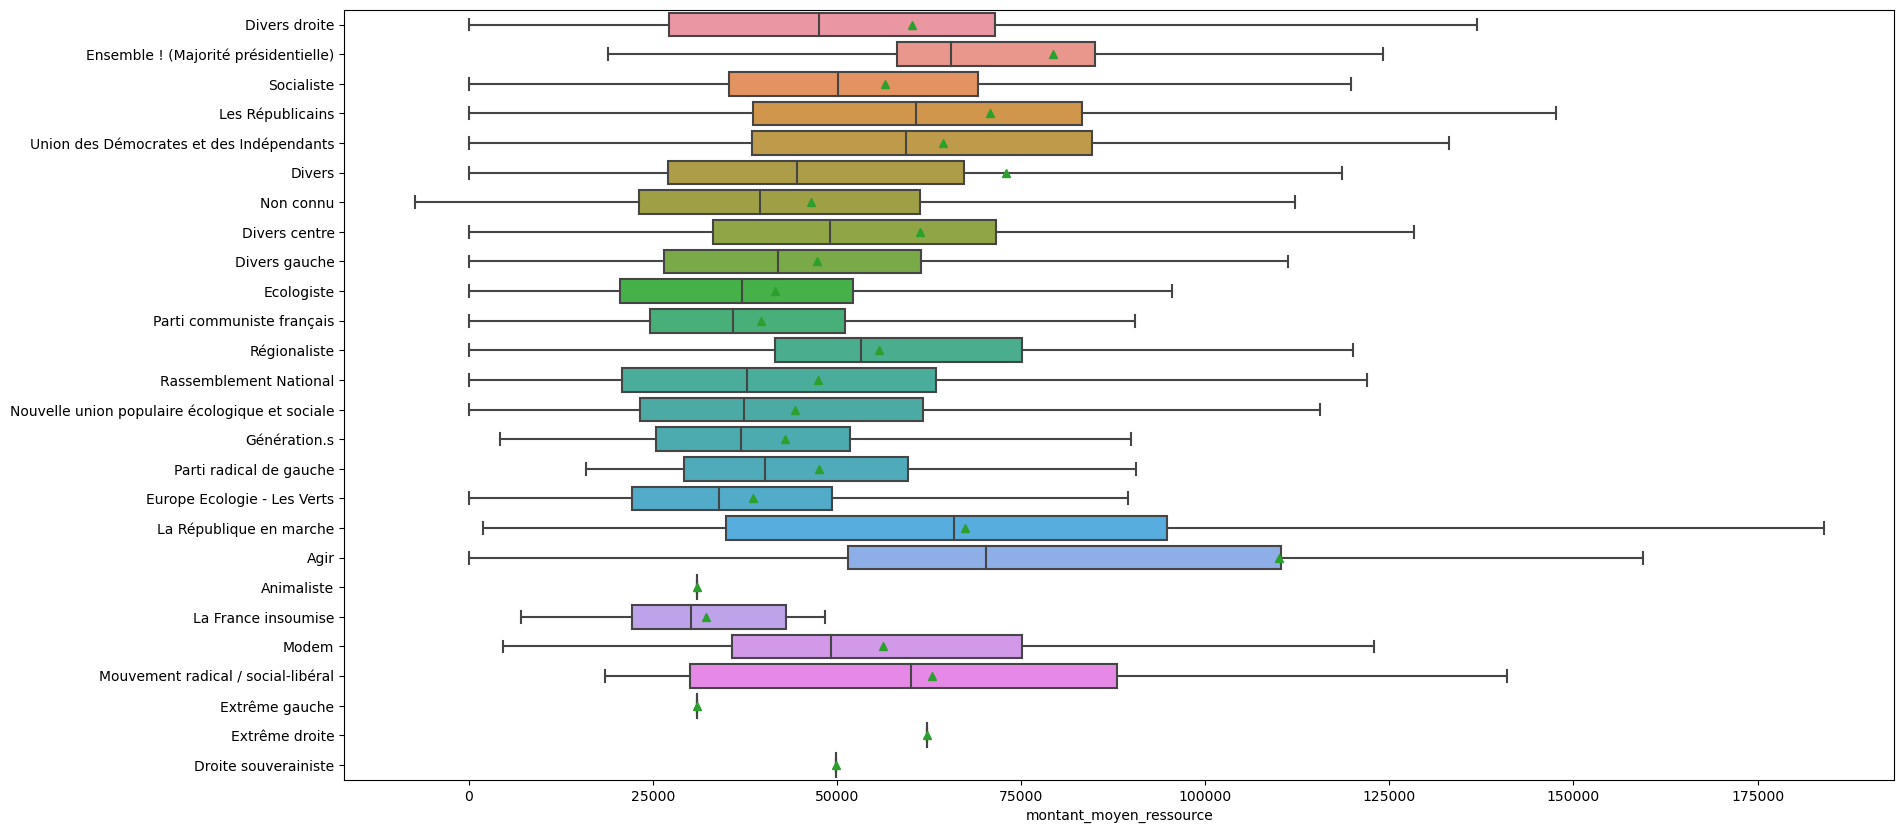

In [137]:
plt.figure(figsize=(20,10))

sns.boxplot(data=data_individus_agg, y='libelle_nuance_mandat', x='montant_moyen_ressource',
            showfliers=False, showmeans=True)

plt.ylabel(None);

In [138]:
data_individus_agg.head()

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes,libelle_departement,libelle_nuance_mandat
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00",2.00,Ain,Divers droite
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00,Isère,Ensemble ! (Majorité présidentielle)
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN,1.40,Gers,Socialiste
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00",4.00,Meuse,Les Républicains
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN,1.11,NaN,NaN


In [139]:
data_individus_agg[data_individus_agg['montant_participation_financiere']>100000]

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes,libelle_departement,libelle_nuance_mandat
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00,Isère,Ensemble ! (Majorité présidentielle)
30,30,Mme,AKPINAR-ISTIQUAM,NURAY,Maire ou adjoint municipal,"30,884.75","160,000.00",1.88,Côte-D'Or,Socialiste
31,31,Mme,ALAIN,VALERIE,Elu départemental,"363,901.50","763,603.00",1.00,Orne,Divers droite
49,49,M.,ALLOTO,MAXENCE,Maire ou adjoint municipal,"42,760.92","101,700.00",1.89,Isère,Socialiste
63,64,M.,AMSLER,JEAN-DANIEL,Elu départemental,"47,347.57","767,880.00",4.00,Val-De-Marne,Les Républicains
...,...,...,...,...,...,...,...,...,...,...
5787,5837,Mme,VAUTRIN,CATHERINE,Membre d’EPCI,"63,013.67","311,130.00",2.00,NaN,NaN
5792,5842,M.,VERNIN,FRANCK,Maire ou adjoint municipal,"129,616.29","204,000.00",4.86,Seine-Et-Marne,Union des Démocrates et des Indépendants
5806,5856,M.,VOGEL,JEAN PIERRE,Sénateur,"182,953.00","1,326,140.00",3.33,Sarthe,Les Républicains
5817,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,"47,382.93","759,673.00",2.00,NaN,NaN


In [140]:
bilan_parti = pd.DataFrame()
partis = []
mean_montants = []
mean_financiers = []
mean_activites = []
nombre_personnes = []
nombre_personne_riche_montants = []
nombre_personne_riche_finances = []

data_individus_agg['libelle_nuance_mandat'][data_individus_agg['libelle_nuance_mandat'].notna()]

for partie_politique in data_individus_agg['libelle_nuance_mandat'][data_individus_agg['libelle_nuance_mandat'].notna()].unique():
        
    df_parti = data_individus_agg[data_individus_agg['libelle_nuance_mandat']==partie_politique]
    mean_montant = df_parti['montant_moyen_ressource'].mean()
    mean_financier = df_parti['montant_participation_financiere'].mean()
    mean_activite = df_parti['nombre_activites_payees_moyennes'].mean()
    nombre_personne = df_parti.shape[0]
    nombre_personne_riche_montant = df_parti[df_parti['montant_moyen_ressource']>100000].shape[0]
    nombre_personne_riche_finance = df_parti[df_parti['montant_participation_financiere']>100000].shape[0]
    
    partis.append(partie_politique)
    mean_montants.append(mean_montant)
    mean_financiers.append(mean_financier)
    mean_activites.append(mean_activite)
    nombre_personnes.append(nombre_personne)
    nombre_personne_riche_montants.append(nombre_personne_riche_montant)
    nombre_personne_riche_finances.append(nombre_personne_riche_finance)

In [141]:
bilan_parti['parti_politique'] = partis
bilan_parti['revenu_moyen'] = mean_montants
bilan_parti['finance_moyen'] = mean_financiers
bilan_parti['activites_payes_moyen'] = mean_activites
bilan_parti['nombre_adherent'] = nombre_personnes
bilan_parti['revenu>100000'] = nombre_personne_riche_montants
bilan_parti['finance>100000'] = nombre_personne_riche_finances

bilan_parti.sort_values('nombre_adherent', ascending=False)

,parti_politique,revenu_moyen,finance_moyen,activites_payes_moyen,nombre_adherent,revenu>100000,finance>100000
0,Divers droite,"60,198.88","718,650.73",2.51,874,113,135
3,Les Républicains,"70,779.21","3,124,561.25",2.67,798,126,136
2,Socialiste,"56,554.53","664,775.31",2.40,596,39,25
8,Divers gauche,"47,284.77","415,694.38",2.15,545,22,31
6,Non connu,"46,485.00","384,596.71",2.44,380,16,29
5,Divers,"72,920.31","188,507.19",2.02,300,35,26
1,Ensemble ! (Majorité présidentielle),"79,354.55","1,079,163.05",1.81,208,33,49
4,Union des Démocrates et des Indépendants,"64,422.73","179,966.80",2.67,198,25,14
7,Divers centre,"61,229.02","222,080.98",2.37,192,18,23
16,Europe Ecologie - Les Verts,"38,614.15","133,461.92",1.80,142,3,6


In [142]:
data_individus_agg.describe()

,id_individu,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes
count,"5,819.00","5,819.00","1,879.00","5,769.00"
mean,"2,933.13","58,437.95","987,964.94",2.32
std,"1,693.26","73,054.69","16,598,678.96",1.19
min,0.00,"-7,335.71","-91,362.00",1.00
25%,"1,468.50","29,665.25","1,000.00",1.33
50%,"2,931.00","48,288.17","23,000.00",2.00
75%,"4,397.50","71,187.43","180,000.00",3.00
max,"5,868.00","2,925,000.00","615,770,727.00",14.60


In [143]:
data_individus_agg

,id_individu,civilite,nom,prenom,qualite_mandat_label_type_mandat,montant_moyen_ressource,montant_participation_financiere,nombre_activites_payees_moyennes,libelle_departement,libelle_nuance_mandat
0,0,M.,ABAD,DAMIEN,Député,"78,579.88","12,268.00",2.00,Ain,Divers droite
1,1,Mme,ABADIE,CAROLINE,Député,"60,225.92","299,100.00",1.00,Isère,Ensemble ! (Majorité présidentielle)
2,2,Mme,ABADIE,MURIEL,Elu régional,"39,249.00",NaN,1.40,Gers,Socialiste
3,3,M.,ABBAS,GERARD,Elu départemental,"39,760.29","4,848.00",4.00,Meuse,Les Républicains
4,4,Mme,ABDUL MALAK,RIMA,Membre du Gouvernement,"95,620.78",NaN,1.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5814,5864,M.,YVON,RICHARD,Type mandat manquant,"116,020.43","15,405.00",1.00,Maine-Et-Loire,Divers droite
5815,5865,M.,ZANARDO,JACKY,Elu départemental,"84,265.14",NaN,1.27,Meurthe-Et-Moselle,Parti communiste français
5816,5866,M.,ZEDET,CHRISTIAN,Membre d’EPCI,"71,819.83",NaN,1.33,Alpes-Maritimes,Divers
5817,5867,Mme,ZERKANI,KARIMA,Maire ou adjoint municipal,"47,382.93","759,673.00",2.00,NaN,NaN


In [144]:
data

,id_declaration,id_individu,date_depot,type_declaration_label,type_declaration_id,qualite_mandat_label_type_mandat,qualite_mandat_nom_categorie_mandat,civilite,date_naissance,nom,prenom,id_activite,id_ressource,annee,montant,origine_ressource,employeur_activProfCinqDerniereDto,description_activProfCinqDerniereDto,societe_participationDirigeantDto,employeur_activConsultantDto
0,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,42,2021,"16,384.00",mandatElectifDto,NaN,NaN,NaN,NaN
1,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m8,43,2022,"6,827.00",mandatElectifDto,NaN,NaN,NaN,NaN
2,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,44,2017,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
3,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,45,2018,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
4,10647,0,2022-11-27 18:18:23,Déclaration d'intérêts et d'activités modifica...,DIA,Député,Député ou sénateur,M.,05/04/1980,ABAD,DAMIEN,m9,46,2019,0.00,mandatElectifDto,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204562,1077,5868,2021-06-25 13:29:08,Déclaration d'intérêts modificative,DI,Maire ou adjoint municipal,Elu local ou membre d’EPCI,M.,08/03/1965,ZUILI,NICOLAS,d52217,324860,2020,0.00,participationDirigeantDto,NaN,NaN,SPL ROUEN NORMANDIE,NaN
204563,1077,5868,2021-06-25 13:29:08,Déclaration d'intérêts modificative,DI,Maire ou adjoint municipal,Elu local ou membre d’EPCI,M.,08/03/1965,ZUILI,NICOLAS,d52216,324859,2021,0.00,participationDirigeantDto,NaN,NaN,SEM ROUEN PARK,NaN
204564,1077,5868,2021-06-25 13:29:08,Déclaration d'intérêts modificative,DI,Maire ou adjoint municipal,Elu local ou membre d’EPCI,M.,08/03/1965,ZUILI,NICOLAS,d52216,324858,2020,0.00,participationDirigeantDto,NaN,NaN,SEM ROUEN PARK,NaN
204565,1077,5868,2021-06-25 13:29:08,Déclaration d'intérêts modificative,DI,Maire ou adjoint municipal,Elu local ou membre d’EPCI,M.,08/03/1965,ZUILI,NICOLAS,p13449,435158,2016,"112,534.00",activProfCinqDerniereDto,NICOLAS ZUILI,CHIRURGIEN DENTISTE,NaN,NaN


## Préparation Power BI

In [217]:
parties_politiques['libelle_nuance_mandat'] = parties_politiques['libelle_nuance_mandat'].str.replace('Extrême droite',
                                                        'Divers droite').str.replace('Extrême gauche',
                                                                                              'Divers gauche').str.replace('Droite souverainiste',
                                                                                                                           'Divers droite').str.replace('Animaliste', 'Ecologiste')

In [218]:
individus_power_bi = declarations_ind.drop(columns=['date_depot', 'type_declaration_id', 'type_declaration_label', 'qualite_mandat_nom_categorie_mandat'])
individus_power_bi.head()

,id_declaration,id_individu,qualite_mandat_label_type_mandat,civilite,date_naissance,nom,prenom
0,10647,0,Député,M.,05/04/1980,ABAD,DAMIEN
1,8289,1,Député,Mme,07/09/1976,ABADIE,CAROLINE
2,7293,2,Elu régional,Mme,09/11/1970,ABADIE,MURIEL
3,6865,3,Elu départemental,M.,07/06/1944,ABBAS,GERARD
4,1878,4,Membre du Gouvernement,Mme,11/02/1979,ABDUL MALAK,RIMA


In [219]:
individus_power_bi = pd.merge(individus_power_bi, parties_politiques[['id_individu', 'code_departement', 'libelle_departement',
                                                    'libelle_nuance_mandat']], how='left', on='id_individu')
individus_power_bi.head()

,id_declaration,id_individu,qualite_mandat_label_type_mandat,civilite,date_naissance,nom,prenom,code_departement,libelle_departement,libelle_nuance_mandat
0,10647,0,Député,M.,05/04/1980,ABAD,DAMIEN,01,Ain,Divers droite
1,8289,1,Député,Mme,07/09/1976,ABADIE,CAROLINE,38,Isère,Ensemble ! (Majorité présidentielle)
2,7293,2,Elu régional,Mme,09/11/1970,ABADIE,MURIEL,32,Gers,Socialiste
3,6865,3,Elu départemental,M.,07/06/1944,ABBAS,GERARD,55,Meuse,Les Républicains
4,1878,4,Membre du Gouvernement,Mme,11/02/1979,ABDUL MALAK,RIMA,NaN,NaN,NaN


In [220]:
codes = []

for code in individus_power_bi['code_departement']:
    
    try :
        code = str(code)
        code = code.replace('.0', '')
    except Exception as error:
        print(error)
        
    codes.append(code)

In [221]:
individus_power_bi['code_departement'] = codes

In [222]:
individus_power_bi = individus_power_bi.fillna('manquant').replace('nan', 'manquant')

In [223]:
departement = individus_power_bi[['code_departement', 'libelle_departement']].drop_duplicates().sort_values('code_departement')

In [224]:
# suppression doublon code departement 69 (Rhone et Rhone hors metropole de Lyon)
departement = departement.drop(100)

In [225]:
individus_power_bi = individus_power_bi.drop(columns='libelle_departement')

In [226]:
data_financiere_power_bi = data_financiere[['id_declaration', 'nom_societe_nettoye',
                                            'evaluation']].rename(columns={'nom_societe_nettoye':'nom_societe'})
data_financiere_power_bi.head()

,id_declaration,nom_societe,evaluation
0,10647,AIRBUS,1929
1,10647,ORANGE,877
2,10647,CREDIT AGRICOLE SA,2910
3,10647,L'OREAL,6552
4,8289,SCI,296100


In [227]:
ressources_power_bi = data[['id_declaration', 'origine_ressource', 'annee', 'montant']]
ressources_power_bi.head()

,id_declaration,origine_ressource,annee,montant
0,10647,mandatElectifDto,2021,"16,384.00"
1,10647,mandatElectifDto,2022,"6,827.00"
2,10647,mandatElectifDto,2017,0.00
3,10647,mandatElectifDto,2018,0.00
4,10647,mandatElectifDto,2019,0.00


In [228]:
# on enlève les doublons --> voir fin

In [229]:
def retirage_doublons_df(df, id_doublons):

    doublons_a_rajoute = df[df['id_declaration'].isin(id_doublons)].drop_duplicates()

    df_sans_doublons = df.drop(df[df['id_declaration'].isin(id_doublons)].index)
    
    print(f"Dans le df, les doublons concernaient {doublons_a_rajoute.shape} lignes.")

    df2 = pd.concat((df_sans_doublons, doublons_a_rajoute), axis=0)
    
    print(f"Dans le df, on a retiré {df.shape[0] - df2.shape[0]} lignes.")
    
    return df2

In [230]:
ressources_power_bi = retirage_doublons_df(ressources_power_bi, id_doublons)

data_financiere_power_bi = retirage_doublons_df(data_financiere_power_bi, id_doublons)

Dans le df, les doublons concernaient (141, 4) lignes.
Dans le df, on a retiré 283 lignes.
Dans le df, les doublons concernaient (5, 3) lignes.
Dans le df, on a retiré 5 lignes.


In [231]:
encodeur_annee = LabelEncoder()

ressources_power_bi['code_annee'] = encodeur_annee.fit_transform(ressources_power_bi['annee'])
ressources_power_bi

,id_declaration,origine_ressource,annee,montant,code_annee
0,10647,mandatElectifDto,2021,"16,384.00",11
1,10647,mandatElectifDto,2022,"6,827.00",12
2,10647,mandatElectifDto,2017,0.00,7
3,10647,mandatElectifDto,2018,0.00,8
4,10647,mandatElectifDto,2019,0.00,9
...,...,...,...,...,...
186170,2651,mandatElectifDto,2018,"81,900.00",8
186171,2651,mandatElectifDto,2015,"81,900.00",5
186186,2651,mandatElectifDto,2019,"27,300.00",9
186187,2651,mandatElectifDto,2017,"81,900.00",7


In [232]:
annee = ressources_power_bi[['code_annee', 'annee']].drop_duplicates().sort_values('annee')
annee

,code_annee,annee
2651,0,2010
322,1,2011
323,2,2012
324,3,2013
136,4,2014
18,5,2015
17,6,2016
2,7,2017
3,8,2018
4,9,2019


In [233]:
ressources_power_bi = ressources_power_bi[['id_declaration', 'origine_ressource', 'code_annee', 'montant']]
ressources_power_bi

,id_declaration,origine_ressource,code_annee,montant
0,10647,mandatElectifDto,11,"16,384.00"
1,10647,mandatElectifDto,12,"6,827.00"
2,10647,mandatElectifDto,7,0.00
3,10647,mandatElectifDto,8,0.00
4,10647,mandatElectifDto,9,0.00
...,...,...,...,...
186170,2651,mandatElectifDto,8,"81,900.00"
186171,2651,mandatElectifDto,5,"81,900.00"
186186,2651,mandatElectifDto,9,"27,300.00"
186187,2651,mandatElectifDto,7,"81,900.00"


In [234]:
activites_payees = ressources_power_bi[ressources_power_bi['montant']>0].groupby(['id_declaration', 'origine_ressource',
                                                               'code_annee'])[['montant']].count().reset_index().rename(columns={'montant':'activites_payees'})

In [235]:
ressources_power_bi_group = ressources_power_bi.groupby(['id_declaration', 'origine_ressource',
                                                         'code_annee'])['montant'].sum().reset_index()

In [236]:
ressources_power_bi_group = pd.merge(ressources_power_bi_group, activites_payees, on=['id_declaration', 'origine_ressource',
                                                         'code_annee'], how='left').fillna(0)

In [237]:
ressources_power_bi_group

,id_declaration,origine_ressource,code_annee,montant,activites_payees
0,1,activProfCinqDerniereDto,5,"6,362.00",1.00
1,1,activProfCinqDerniereDto,6,"6,698.00",1.00
2,1,activProfCinqDerniereDto,7,"7,425.00",1.00
3,1,activProfCinqDerniereDto,8,"1,891.00",1.00
4,3,mandatElectifDto,5,"71,225.00",2.00
...,...,...,...,...,...
78070,10871,participationDirigeantDto,7,"54,000.00",1.00
78071,10871,participationDirigeantDto,8,"54,000.00",1.00
78072,10871,participationDirigeantDto,9,"55,800.00",1.00
78073,10871,participationDirigeantDto,10,"72,000.00",1.00


## Export Power BI

In [238]:
print(departement.shape)
departement

(106, 2)


,code_departement,libelle_departement
0,01,Ain
304,02,Aisne
9,03,Allier
265,04,Alpes-De-Haute-Provence
91,05,Hautes-Alpes
159,06,Alpes-Maritimes
98,07,Ardèche
130,08,Ardennes
350,09,Ariège
242,10,Aube


In [239]:
departement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 4
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   code_departement     106 non-null    object
 1   libelle_departement  106 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [240]:
print(individus_power_bi.shape)
individus_power_bi.head()

(5891, 9)


,id_declaration,id_individu,qualite_mandat_label_type_mandat,civilite,date_naissance,nom,prenom,code_departement,libelle_nuance_mandat
0,10647,0,Député,M.,05/04/1980,ABAD,DAMIEN,01,Divers droite
1,8289,1,Député,Mme,07/09/1976,ABADIE,CAROLINE,38,Ensemble ! (Majorité présidentielle)
2,7293,2,Elu régional,Mme,09/11/1970,ABADIE,MURIEL,32,Socialiste
3,6865,3,Elu départemental,M.,07/06/1944,ABBAS,GERARD,55,Les Républicains
4,1878,4,Membre du Gouvernement,Mme,11/02/1979,ABDUL MALAK,RIMA,manquant,manquant


In [241]:
individus_power_bi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5891 entries, 0 to 5890
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id_declaration                    5891 non-null   int64 
 1   id_individu                       5891 non-null   int64 
 2   qualite_mandat_label_type_mandat  5891 non-null   object
 3   civilite                          5891 non-null   object
 4   date_naissance                    5891 non-null   object
 5   nom                               5891 non-null   object
 6   prenom                            5891 non-null   object
 7   code_departement                  5891 non-null   object
 8   libelle_nuance_mandat             5891 non-null   object
dtypes: int64(2), object(7)
memory usage: 460.2+ KB


In [242]:
print(data_financiere_power_bi.shape)
data_financiere_power_bi.head()

(6153, 3)


,id_declaration,nom_societe,evaluation
0,10647,AIRBUS,1929
1,10647,ORANGE,877
2,10647,CREDIT AGRICOLE SA,2910
3,10647,L'OREAL,6552
4,8289,SCI,296100


In [243]:
data_financiere_power_bi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6153 entries, 0 to 5453
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_declaration  6153 non-null   int64 
 1   nom_societe     6153 non-null   object
 2   evaluation      6153 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 192.3+ KB


In [244]:
print(ressources_power_bi.shape)
ressources_power_bi.head()

(204282, 4)


,id_declaration,origine_ressource,code_annee,montant
0,10647,mandatElectifDto,11,"16,384.00"
1,10647,mandatElectifDto,12,"6,827.00"
2,10647,mandatElectifDto,7,0.00
3,10647,mandatElectifDto,8,0.00
4,10647,mandatElectifDto,9,0.00


In [245]:
ressources_power_bi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204282 entries, 0 to 186188
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_declaration     204282 non-null  int64  
 1   origine_ressource  204282 non-null  object 
 2   code_annee         204282 non-null  int64  
 3   montant            204282 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 7.8+ MB


In [246]:
print(ressources_power_bi_group.shape)
ressources_power_bi_group

(78075, 5)


,id_declaration,origine_ressource,code_annee,montant,activites_payees
0,1,activProfCinqDerniereDto,5,"6,362.00",1.00
1,1,activProfCinqDerniereDto,6,"6,698.00",1.00
2,1,activProfCinqDerniereDto,7,"7,425.00",1.00
3,1,activProfCinqDerniereDto,8,"1,891.00",1.00
4,3,mandatElectifDto,5,"71,225.00",2.00
...,...,...,...,...,...
78070,10871,participationDirigeantDto,7,"54,000.00",1.00
78071,10871,participationDirigeantDto,8,"54,000.00",1.00
78072,10871,participationDirigeantDto,9,"55,800.00",1.00
78073,10871,participationDirigeantDto,10,"72,000.00",1.00


In [247]:
ressources_power_bi_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78075 entries, 0 to 78074
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_declaration     78075 non-null  int64  
 1   origine_ressource  78075 non-null  object 
 2   code_annee         78075 non-null  int64  
 3   montant            78075 non-null  float64
 4   activites_payees   78075 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 3.6+ MB


In [248]:
annee.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 2651 to 1327
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   code_annee  14 non-null     int64
 1   annee       14 non-null     int64
dtypes: int64(2)
memory usage: 336.0 bytes


In [249]:
# export
departement.to_csv(folder_powerbi + 'departement.csv', index=False)
individus_power_bi.to_csv(folder_powerbi + 'individus_power_bi.csv', index=False)
data_financiere_power_bi.to_csv(folder_powerbi + 'data_financiere_power_bi.csv', index=False)
ressources_power_bi.to_csv(folder_powerbi + 'ressources_power_bi.csv', index=False)
ressources_power_bi_group.to_csv(folder_powerbi + 'ressources_power_bi_group.csv', index=False)
annee.to_csv(folder_powerbi + 'annee.csv', index=False)

In [250]:
data_financiere_power_bi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6153 entries, 0 to 5453
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_declaration  6153 non-null   int64 
 1   nom_societe     6153 non-null   object
 2   evaluation      6153 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 192.3+ KB


# Suppression des doublons au sein d'une meme déclaration

Voici les numéros de déclaration concernés.

On enlève ces declarations  
On supprime les doublons pour ces déclarations  
on rajoute ces déclarations avec les doublons enlevés  

In [203]:
id_doublons = [ 3986,  3986,  6835,  6835, 10808, 10808,  4301,  4301,  4893,
        4893,  1538,  1538,  9089,  9089,  5161,  5161,  9677,  9677,
        8434,  8434,  9399,  9399,  6697,  6697,  5369,  5369,  4718,
        4718,  6172,  6172,  9111,  9111,  3404,  3404,  9132,  9132,
        2651,  2651]

In [213]:
def retirage_doublons_df(df, id_doublons):

    doublons_a_rajoute = df[df['id_declaration'].isin(id_doublons)].drop_duplicates()

    df_sans_doublons = df.drop(df[df['id_declaration'].isin(id_doublons)].index)
    
    print(f"Dans le df, les doublons concernaient {doublons_a_rajoute.shape} lignes.")

    df2 = pd.concat((df_sans_doublons, doublons_a_rajoute), axis=0)
    
    print(f"Dans le df, on a retiré {df.shape[0] - df2.shape[0]} lignes.")
    
    return df2

ressources_power_bi2 = retirage_doublons_df(ressources_power_bi, id_doublons)

data_financiere_power_bi2 = retirage_doublons_df(data_financiere_power_bi, id_doublons)

In [212]:
ressources_power_bi_group2 = retirage_doublons_df(ressources_power_bi_group, id_doublons)

Dans le df, les doublons concernant (89, 5) lignes.
Dans le df, on a retiré 0 lignes.
